# Dataworth with Freyberg Pilot Points Model

Here we are going to investigate the sources of forecast uncertainty as well as the worth of observations to reduce forecast uncertainty.  This is essentially the same workflow as used with the ``freyberg_zone_dataworth`` excersize.  Important things to remember:
- FOSM doesn't require values for observations, parameters or forecast.  We do need sensitivities between the quantities and estimates of prior uncertainties for parameters and observtion noise.  
- 

In [1]:
%matplotlib inline
import os
import sys
sys.path.append("..")
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
import pyemu

In [2]:
import freyberg_setup as fs
fs.setup_pest_pp()
working_dir = fs.WORKING_DIR_PP
pst_name = fs.PST_NAME_PP

['.DS_Store', 'botm.ref', 'extract_zone_array.py', 'forecasts_true.csv', 'freyberg.bas', 'freyberg.dbf', 'freyberg.dis', 'freyberg.hds', 'freyberg.heads', 'freyberg.heads_potobs.ins', 'freyberg.hyd', 'freyberg.list', 'freyberg.locations', 'freyberg.mpbas', 'freyberg.mpenpt', 'freyberg.mplist', 'freyberg.mpnam', 'freyberg.mppthln', 'freyberg.mpsim', 'freyberg.oc', 'freyberg.pcg', 'freyberg.rivflux', 'freyberg.shp', 'freyberg.shx', 'freyberg.travel', 'freyberg.truth.lpf', 'freyberg.truth.nam', 'freyberg.truth.rch', 'freyberg.truth.riv', 'freyberg.truth.wel', 'hk.truth.ref', 'hk.zones', 'ibound.ref', 'kzone.ref', 'mpath.in', 'potobs_group.csv', 'Process_output.py', 'really_noisy_heads.txt', 'run_true_model.py', 'strt.ref', 'Weights_and_best_PHI.xlsx']

changing model workspace...
   freyberg_pp
FloPy is using the following executable to run the model: /Users/jwhite/Dev/GW1876/activities/freyberg_pilot_points_dataworth/freyberg_pp/mfnwt

                                  MODFLOW-NWT-SWR1 


In [3]:
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
pst.control_data.noptmax = -1
pst.write(os.path.join(working_dir,pst_name))


In [4]:
os.chdir(working_dir)
pyemu.helpers.start_slaves('.',"pestpp",pst_name,num_slaves=15,master_dir=".")
os.chdir("..")

master:pestpp freyberg_pp.pst /h :4004 in .
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_0
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_1
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_2
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_3
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_4
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_5
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_6
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_7
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_8
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_9
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_10
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_11
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_12
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_13
slave:pestpp freyberg_pp.pst /h localhost:4004 in ../slave_14


In [5]:
sc = pyemu.Schur(os.path.join(working_dir,pst_name.replace(".pst",".jcb")))

A quick check of which parameters are being informed by the observations during calibration:

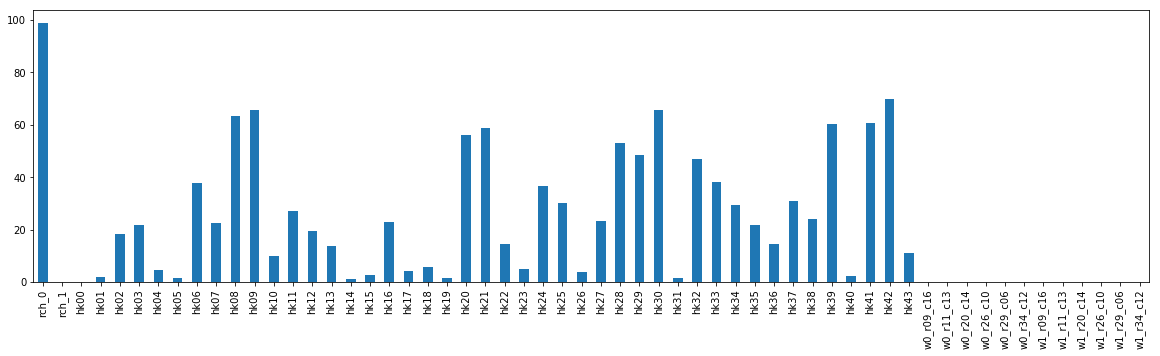

In [6]:
fig = plt.figure(figsize=(20,5))
ax = plt.subplot(111)
sc.get_parameter_summary().percent_reduction.plot(kind="bar",ax=ax)

## Parameter contribution analysis

We are going to use the ``Schur.get_par_contribution()`` method. It calculates the *decrease* in forecast uncertainty resulting for hypothetical "perfect knowledge" (no uncertainty) of arbitrary groups of parameters. If you don't pass any arguments, then it tests each parameter independently:

In [7]:
df_pc = sc.get_par_contribution()


In [8]:
df_pc = 100.0 * (1.0 - df_pc / df_pc.loc["base",:])

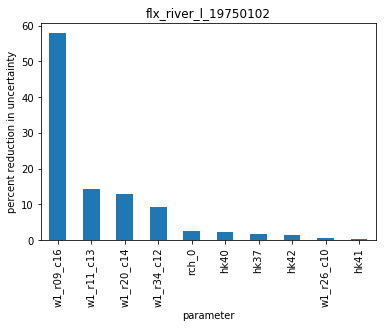

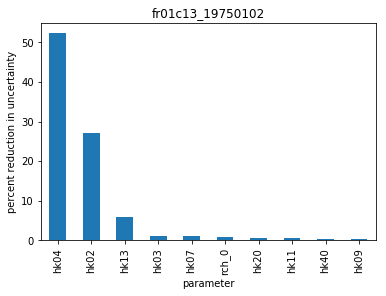

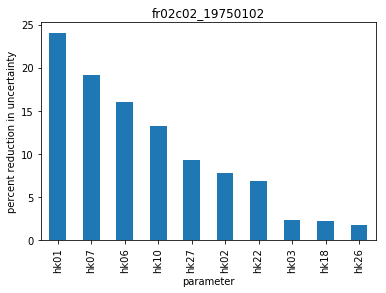

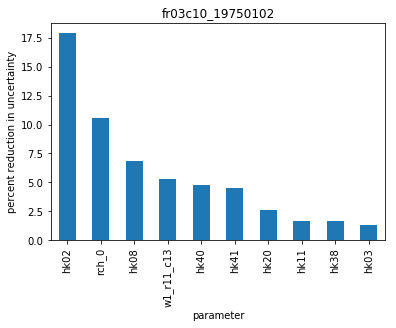

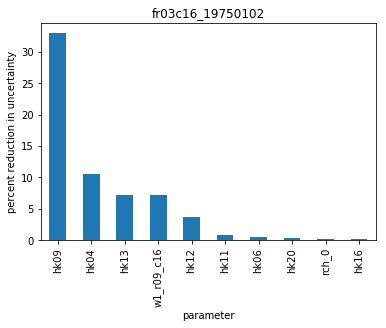

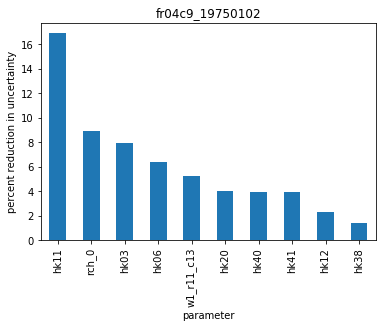

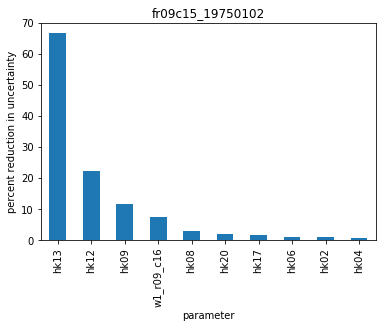

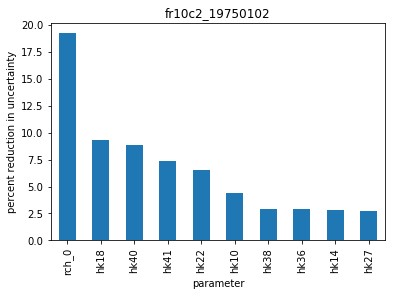

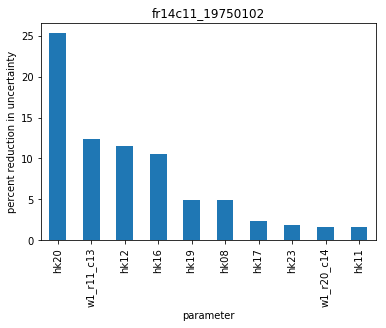

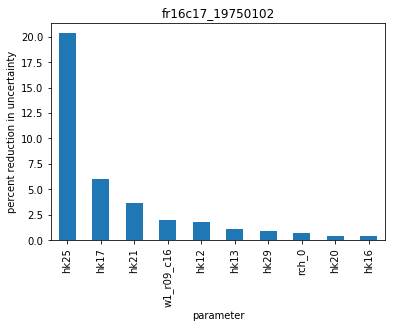

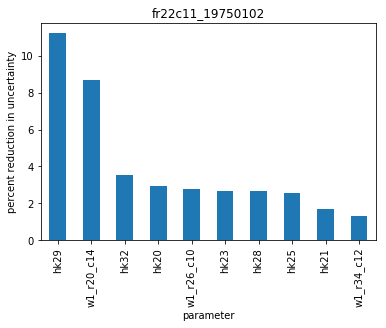

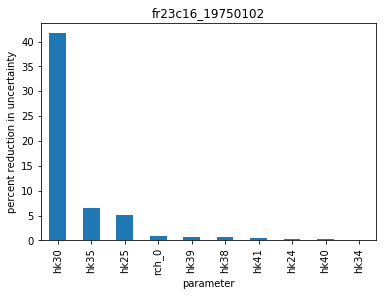

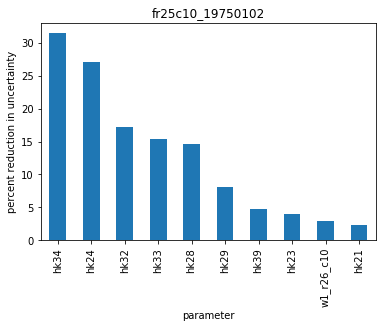

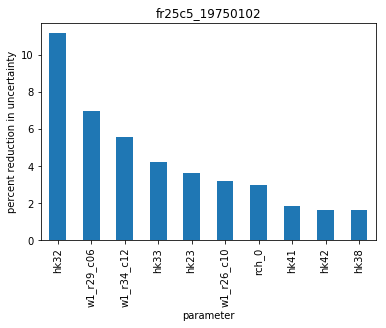

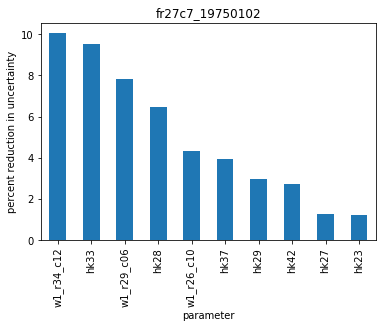

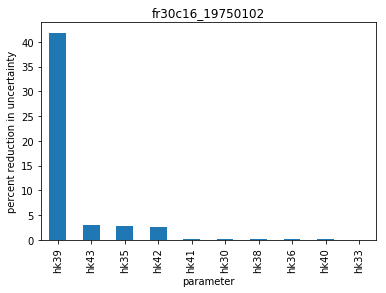

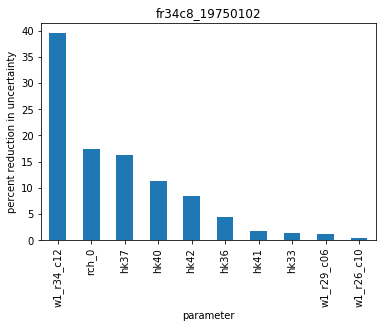

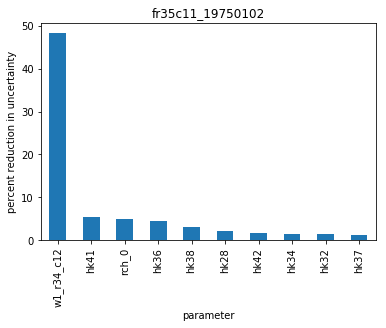

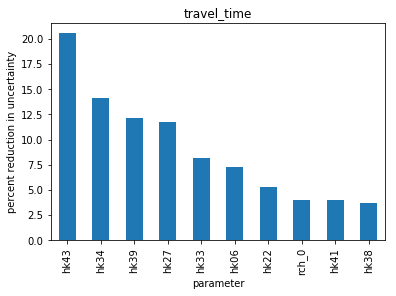

In [9]:
for forecast in df_pc.columns:
    ax = df_pc.sort_values(by=forecast,ascending=False).loc[:,forecast].iloc[:10].plot(kind="bar")
    ax.set_title(forecast)
    ax.set_ylabel("percent reduction in uncertainty")
    ax.set_xlabel("parameter")
    plt.show()

We see a mixture of HK pilot points, recharge, and well pumping rates...so we see that each forecast depends on (potentailly) difference combinations of parameters.  Does this mean we can still make a model that makes several kinds of forecasts???

## Observation worth

Let's see what observations are most important to the forecasts.  We will start be investigating the value of the existing observations using the ``Schur.get_removed_obs_importance()`` method.  It calculates the *increase* in forecast uncertainty that happens if we lose each existing observation. We will start with the existing observations:

In [10]:
df_rm = sc.get_removed_obs_importance()
df_rm

,flx_river_l_19750102,fr01c13_19750102,fr02c02_19750102,fr03c10_19750102,fr03c16_19750102,fr04c9_19750102,fr09c15_19750102,fr10c2_19750102,fr14c11_19750102,fr16c17_19750102,fr22c11_19750102,fr23c16_19750102,fr25c10_19750102,fr25c5_19750102,fr27c7_19750102,fr30c16_19750102,fr34c8_19750102,fr35c11_19750102,travel_time
base,22312.097166,0.021169,0.906806,0.016889,0.021102,0.026779,0.631419,0.050938,0.030625,0.021106,0.019728,0.019652,0.118313,0.036573,0.035037,0.020566,0.042764,0.050698,2.231074e+07
cr03c16_19700102,22312.350287,0.026314,0.907774,0.016890,0.097625,0.027534,0.758933,0.051023,0.030625,0.021550,0.019729,0.019666,0.118320,0.036574,0.035037,0.020566,0.042768,0.050700,2.231093e+07
cr22c11_19700102,22316.559320,0.021172,0.908491,0.016894,0.021104,0.026806,0.631722,0.051220,0.030802,0.021112,0.190710,0.019878,0.259932,0.038280,0.035291,0.020580,0.042881,0.050732,2.375962e+07
cr03c10_19700102,22312.125359,0.033789,0.991335,0.052454,0.021157,0.027936,0.649505,0.050972,0.031376,0.021140,0.019734,0.019652,0.118313,0.036577,0.035044,0.020566,0.042766,0.050701,2.236434e+07
cr04c9_19700102,22312.129470,0.022162,1.052755,0.025261,0.021119,0.096852,0.658791,0.050979,0.031915,0.021164,0.019732,0.019653,0.118313,0.036575,0.035047,0.020566,0.042767,0.050703,2.241964e+07
cr30c16_19700102,22314.307117,0.021175,0.908095,0.016937,0.021103,0.026852,0.631422,0.051142,0.030627,0.021116,0.019743,0.020290,0.121522,0.036825,0.035104,0.129714,0.043064,0.050769,4.436531e+07
flx_river_l_19700102,23026.794259,0.030297,1.381197,0.107550,0.023610,0.149395,0.641767,0.632377,0.043351,0.027455,0.051761,0.024133,0.182926,0.314946,0.214447,0.025928,0.109598,0.061095,3.163120e+07
cr16c17_19700102,22312.272859,0.021187,0.906844,0.016889,0.021171,0.026798,0.635820,0.050943,0.030800,0.160311,0.020606,0.020112,0.120749,0.036587,0.035051,0.020587,0.042764,0.050707,2.234565e+07
cr25c5_19700102,22312.708079,0.021169,0.922838,0.016891,0.021102,0.026799,0.631419,0.050951,0.030703,0.021114,0.019782,0.019660,0.144929,0.621282,0.035229,0.020572,0.042958,0.050726,2.233251e+07
cr35c11_19700102,23092.543140,0.021219,0.907120,0.017372,0.021115,0.027394,0.631481,0.054911,0.030698,0.021163,0.019845,0.019687,0.118899,0.038860,0.037974,0.020729,0.043419,0.248510,3.354287e+07


In [11]:
df_rm = 100.0 * (1.0 - df_rm.loc["base",:] / df_rm)

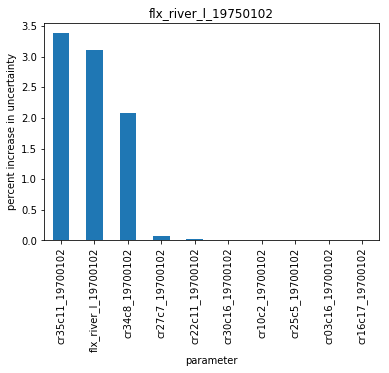

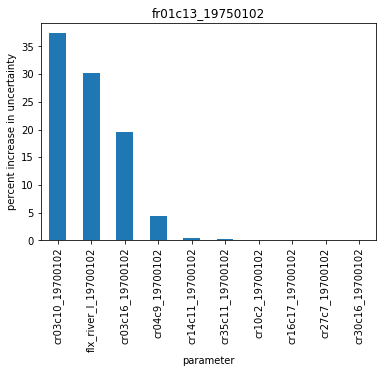

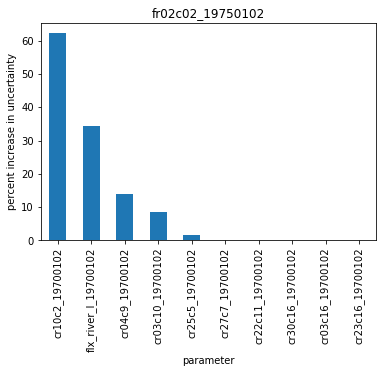

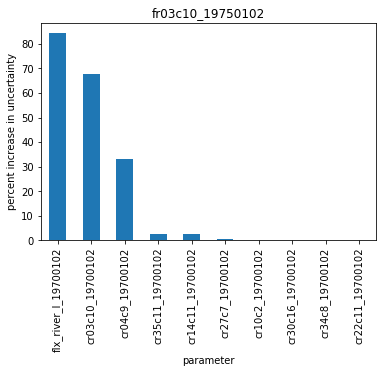

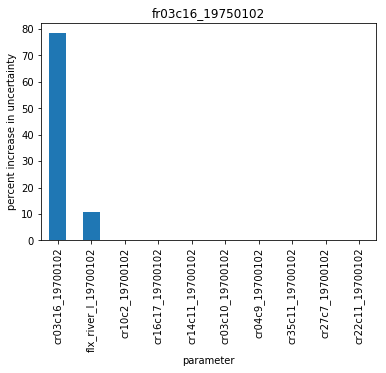

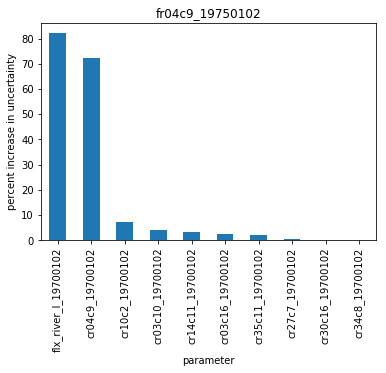

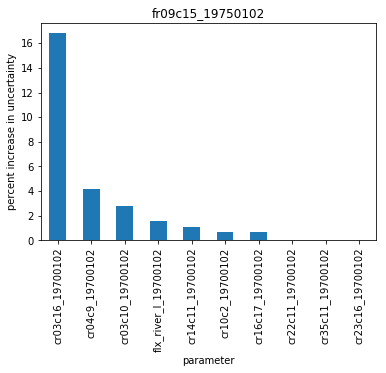

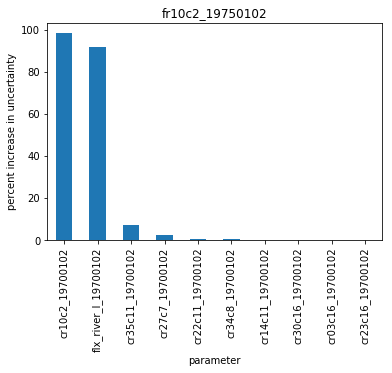

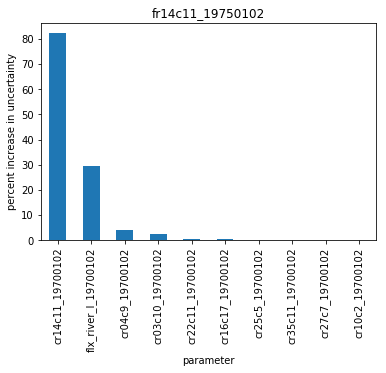

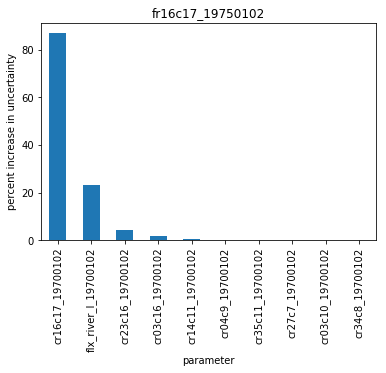

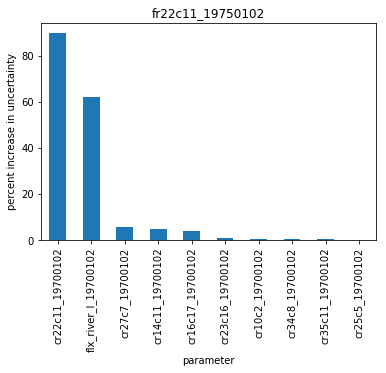

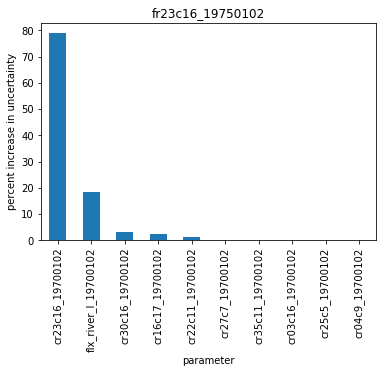

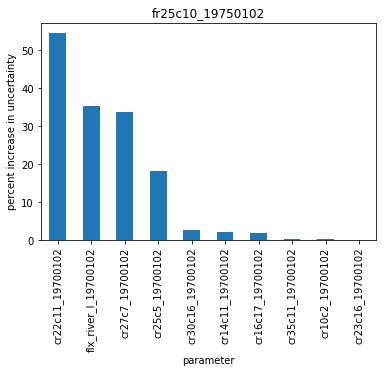

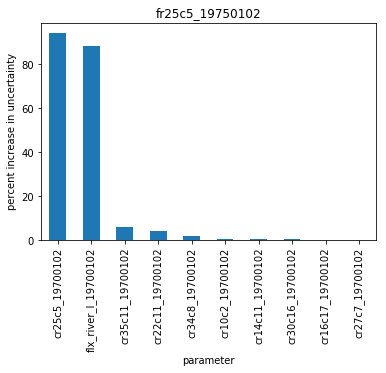

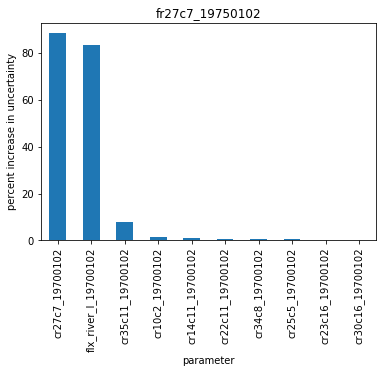

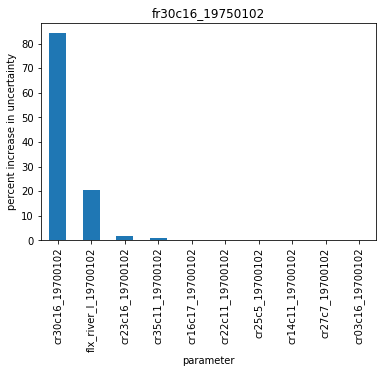

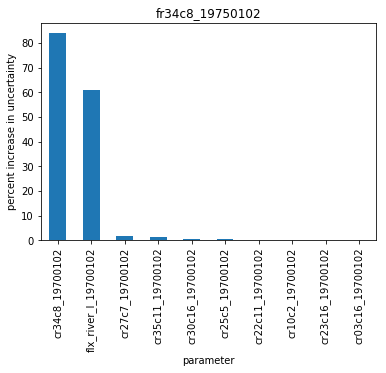

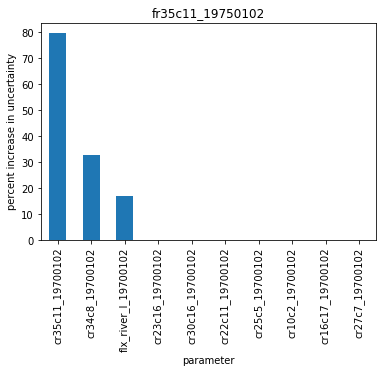

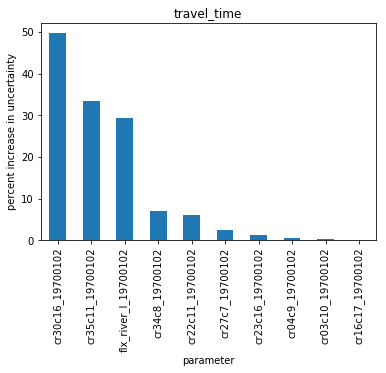

In [12]:
for forecast in df_rm.columns:
    ax = df_rm.sort_values(by=forecast,ascending=False).loc[:,forecast].iloc[:10].plot(kind="bar")
    ax.set_title(forecast)
    ax.set_ylabel("percent increase in uncertainty")
    ax.set_xlabel("parameter")
    plt.show()

### Estimating the value of yet-to-be-collected observations

Using the assumptions of FOSM, we can also calculate the value of observations we don't have yet!  Black magic!  Not really, we carried these possible data locations as ``observations`` in the control file - this means each one has a row in the jacobian (just like any other output of interest).  If we then assume some value of measurement noise (a non-zero weight in the control file), we can run a hypothetical "calibration" analysis using Schur compliment.  Remember, FOSM doesn't care about actual values of parameters, observations, or forecasts, only sensitivities...

In pyemu, the ``Schur.get_added_obs_importance()`` method calculates the *decrease* in uncertainty resulting for having new obsevations during calibration.  It accepts an optional argument ``obslist_dict`` which is a python dictionary of groups of new observations to test.  Here we will test the value of having the water level in each unmeasured model cell.  Then we can make maps of where to collect new data...these calculations take a little while to run because we are repeatedly calculating the entire FOSM process for each new observation location 

In [13]:
pobs_names = [o for o in sc.pst.obs_names if o.startswith("pr")]
df_ad = sc.get_added_obs_importance(obslist_dict={oname:oname for oname in pobs_names},
                                base_obslist=sc.pst.nnz_obs_names,reset_zero_weight=True)

In [14]:
df_ad.min()

flx_river_l_19750102    2.175020e+04
fr01c13_19750102        1.956599e-02
fr02c02_19750102        3.438904e-01
fr03c10_19750102        1.583917e-02
fr03c16_19750102        2.008492e-02
fr04c9_19750102         2.260666e-02
fr09c15_19750102        8.634999e-02
fr10c2_19750102         4.329386e-02
fr14c11_19750102        2.219675e-02
fr16c17_19750102        1.995447e-02
fr22c11_19750102        1.875232e-02
fr23c16_19750102        1.818068e-02
fr25c10_19750102        9.314751e-02
fr25c5_19750102         3.366776e-02
fr27c7_19750102         3.327044e-02
fr30c16_19750102        1.859506e-02
fr34c8_19750102         3.979241e-02
fr35c11_19750102        4.163122e-02
travel_time             1.915509e+07
dtype: float64

In [15]:
df_ad.max()

flx_river_l_19750102    2.231210e+04
fr01c13_19750102        2.116926e-02
fr02c02_19750102        9.068063e-01
fr03c10_19750102        1.688859e-02
fr03c16_19750102        2.110192e-02
fr04c9_19750102         2.677892e-02
fr09c15_19750102        6.314194e-01
fr10c2_19750102         5.093756e-02
fr14c11_19750102        3.062467e-02
fr16c17_19750102        2.110611e-02
fr22c11_19750102        1.972815e-02
fr23c16_19750102        1.965153e-02
fr25c10_19750102        1.183126e-01
fr25c5_19750102         3.657328e-02
fr27c7_19750102         3.503713e-02
fr30c16_19750102        2.056583e-02
fr34c8_19750102         4.276405e-02
fr35c11_19750102        5.069793e-02
travel_time             2.231074e+07
dtype: float64

In [16]:
# just a helper function to make maps of data worth
m = flopy.modflow.Modflow.load(fs.MODEL_NAM,model_ws=working_dir)
obs = pst.observation_data
hobs = obs.loc[obs.obgnme=="calhead",:].copy()
hobs.loc[:,"i"] = hobs.obsnme.apply(lambda x: int(x[2:4])-1)
hobs.loc[:,"j"] = hobs.obsnme.apply(lambda x: int(x.split('_')[0].split('c')[-1])-1)
hobs.loc[:,"x"] = m.sr.xcentergrid[hobs.i,hobs.j]
hobs.loc[:,"y"] = m.sr.ycentergrid[hobs.i,hobs.j]
wdata = pd.DataFrame.from_records(m.wel.stress_period_data[0])
wdata.loc[:,"x"] = m.sr.xcentergrid[wdata.i,wdata.j]
wdata.loc[:,"y"] = m.sr.ycentergrid[wdata.i,wdata.j]
def plot_added_worth(df):
    df_base = df.loc["base",:]
    df_frac = 100.0 * (1.0 - (df / df_base))
    df_frac = df_frac.loc[pobs_names,:]
    df_frac.loc[:,"i"] = df_frac.index.map(lambda x: int(x[2:4]))
    df_frac.loc[:,"j"] = df_frac.index.map(lambda x: int(x[5:7]))
    
    #for forecast in df_frac.columns:
        #if forecast in ["i","j"]:
        #    continue
    for forecast in sc.pst.forecast_names:
        print(forecast)
        arr = np.zeros((m.nrow,m.ncol))
        arr[df_frac.i,df_frac.j] = df_frac.loc[:,forecast]
        arr = np.ma.masked_where(arr <= 0.0 ,arr)
        fig = plt.figure(figsize=(6,10))
        ax = plt.subplot(111)
        #c = ax.imshow(arr,interpolation="nearest",alpha=0.5,extent=m.sr.get_extent())
        c = ax.pcolormesh(m.sr.xedge,m.sr.yedge,arr,alpha=0.75)
        #ax.imshow(zn_arr,interpolation="nearest",alpha=0.5)
        plt.colorbar(c)
        #m.dis.top = arr
        #ax = m.dis.top.plot(alpha=0.5,colorbar=True)
        if forecast.startswith("fr"):
            i = int(forecast[2:4]) - 1
            j = int(forecast.split('_')[0].split('c')[-1]) - 1
            x,y = m.sr.xcentergrid[i,j],m.sr.ycentergrid[i,j]
            ax.scatter([x],[y],marker='o',color='r',s=150)
            
            
        ax.scatter(hobs.x,hobs.y,marker='x',s=100,color='y')
        ax.scatter(wdata.x,wdata.y,marker='*',s=100,color='m')
        ax.set_title(forecast)
        plt.show()

    

Now we are going to plot the worth (reduction in uncertainty) of a single, new water level measurement for each forecast (forecast name is the title of each plot). So these plots show us where to go collect new data to reduce forecast uncertainty as much as possible...red circles show the forecast (for water level forecasts), yellow X's are the locations of existing water levels, purple stars mark pumping well locations (pumping rates are treated as uncertain!)

fr03c16_19750102


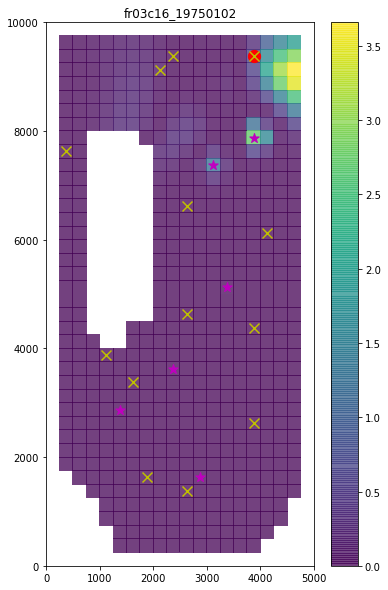

fr03c10_19750102


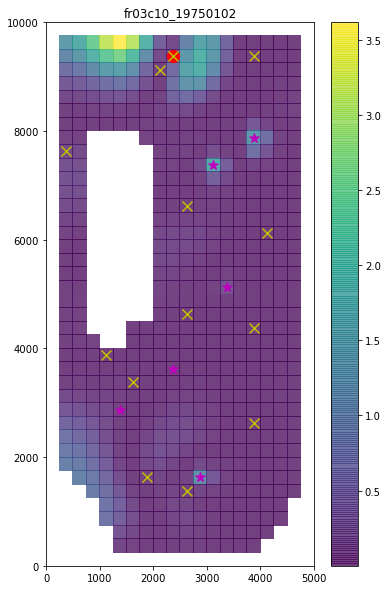

fr04c9_19750102


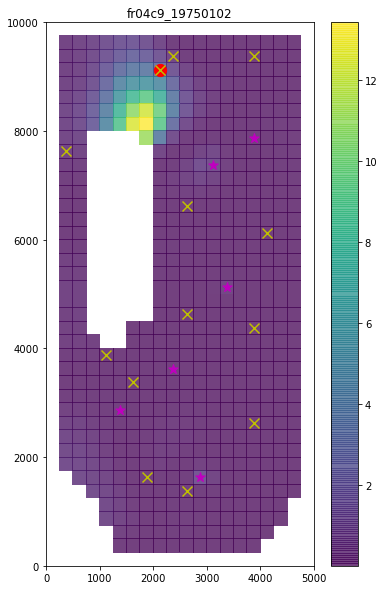

fr10c2_19750102


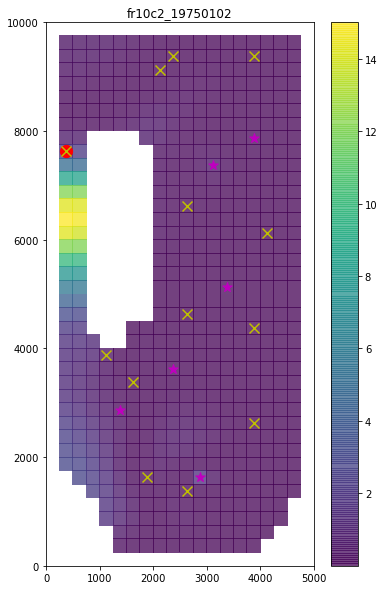

fr14c11_19750102


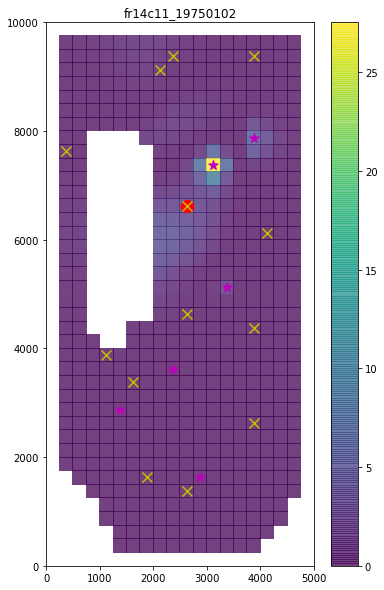

fr16c17_19750102


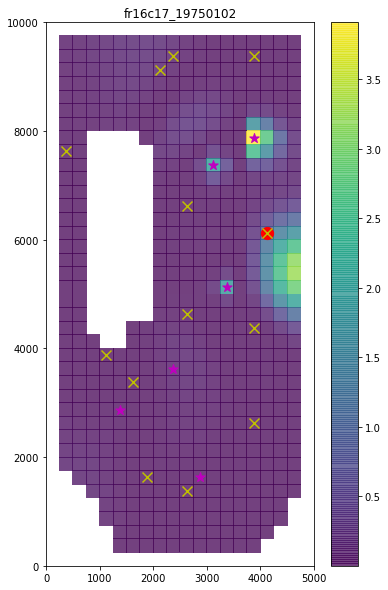

fr22c11_19750102


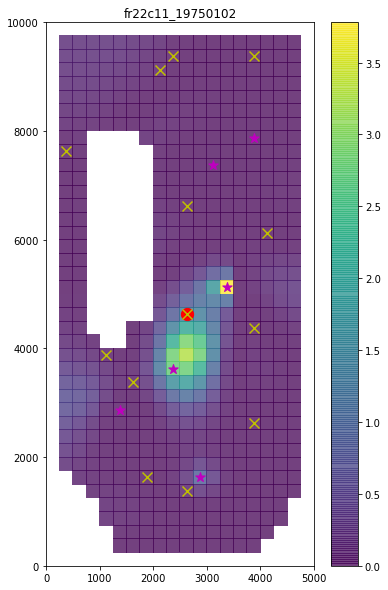

fr23c16_19750102


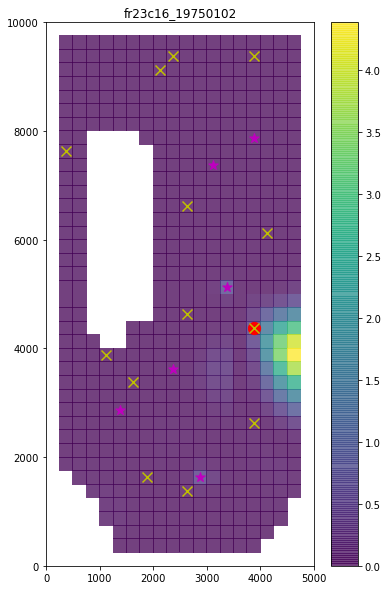

fr25c5_19750102


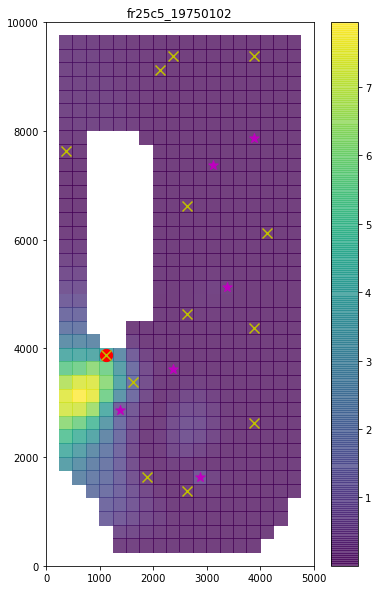

fr27c7_19750102


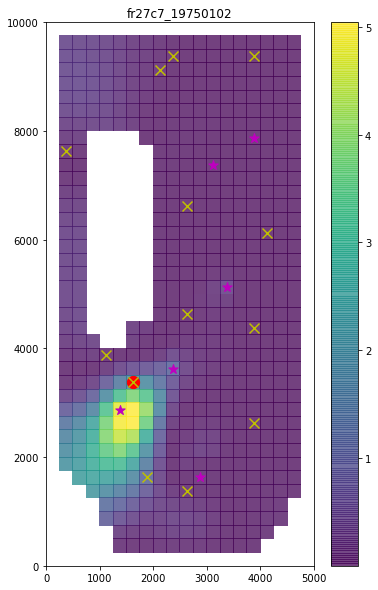

fr30c16_19750102


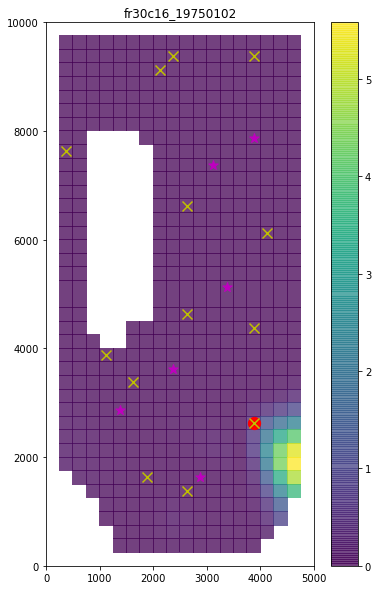

fr34c8_19750102


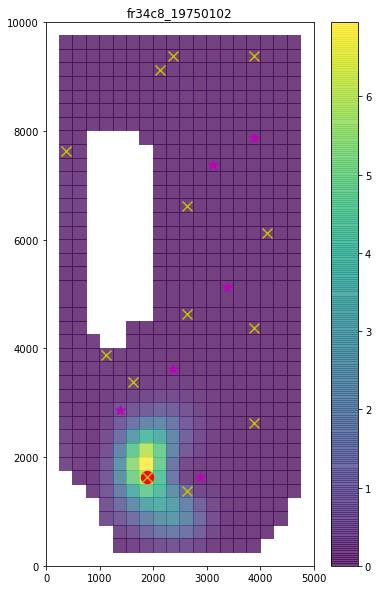

fr35c11_19750102


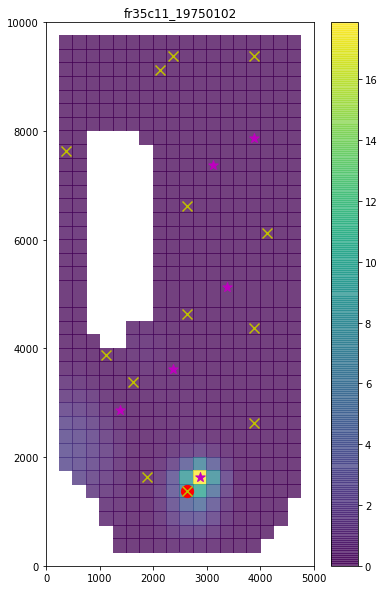

fr02c02_19750102


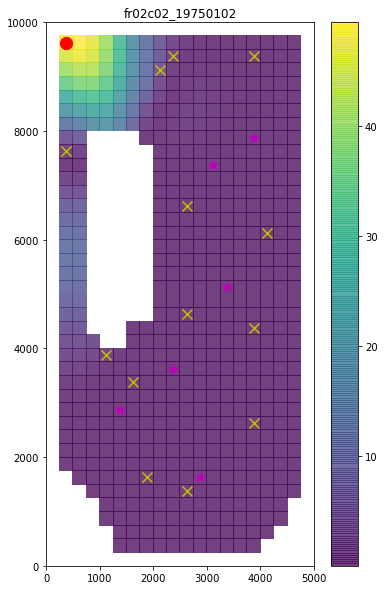

fr01c13_19750102


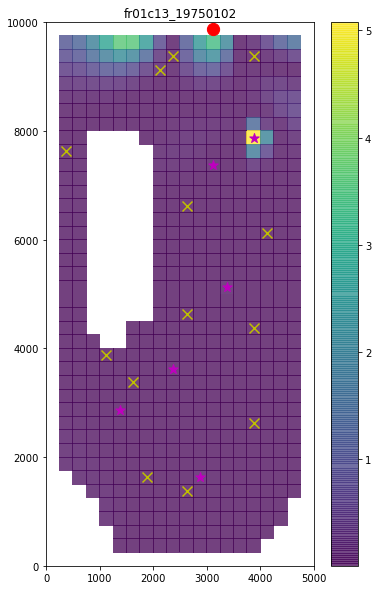

fr09c15_19750102


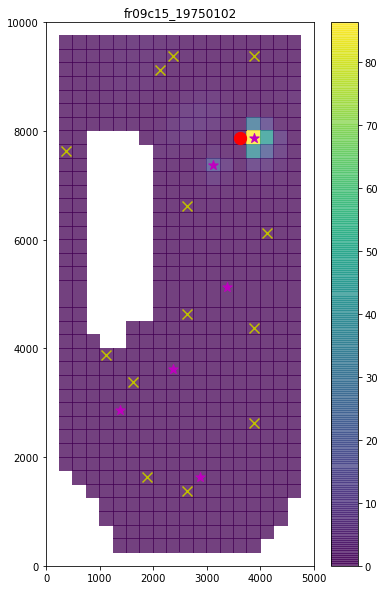

fr25c10_19750102


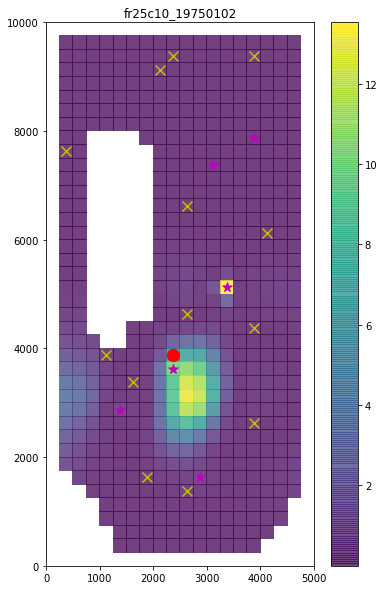

flx_river_l_19750102


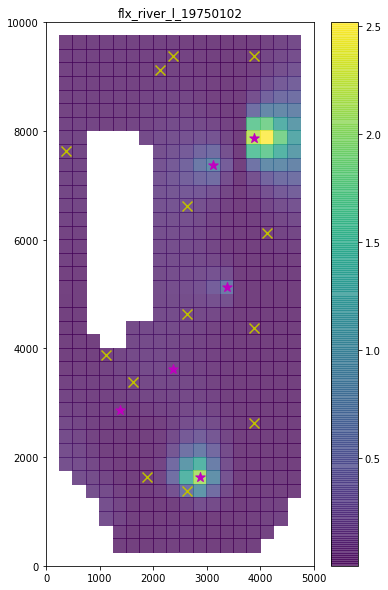

travel_time


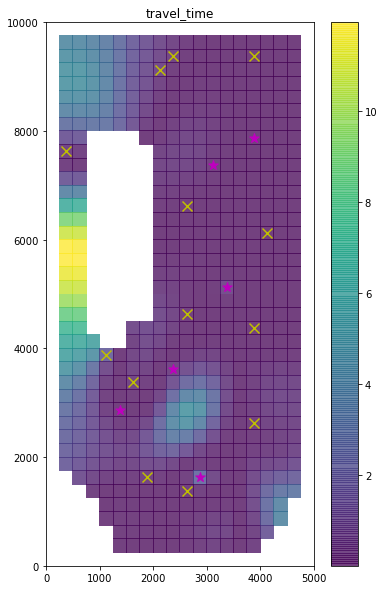

In [17]:
plot_added_worth(df_ad)

Ok, so those are cool.  And, unlike the zoned-parameterization dataworth, these make sense from a physical interpretation standpoint

Let's explore what happens when we use a full covariance prior

In [18]:
v = pyemu.geostats.ExpVario(contribution=1.0,a=2500.0)
gs = pyemu.geostats.GeoStruct(variograms=[v])
cov = pyemu.helpers.pilotpoint_prior_builder(sc.pst,
                            struct_dict={gs:os.path.join(working_dir,"hkpp.dat.tpl")})

/Users/jwhite/Dev/python/pyemu/pyemu/utils/helpers.py:50: UserWarning: 'pilotpoint_prior_builder' has been renamed to 'geostatistical_prior_builder'
  "'geostatistical_prior_builder'")


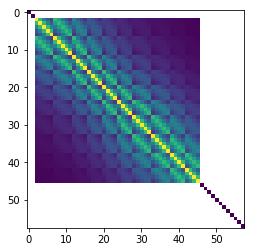

In [19]:
x = np.ma.masked_where(cov.x==0,cov.x)
plt.imshow(x)

In [20]:
sc_full = pyemu.Schur(jco=sc.jco,pst=sc.pst,parcov=cov,forecasts=sc.forecasts,verbose=True)

2017-09-04 10:46:53.883064 starting: pre-loading base components
2017-09-04 10:46:53.883289 starting: loading obscov
2017-09-04 10:46:54.066631 finished: loading obscov took: 0:00:00.183342
2017-09-04 10:46:54.066732 starting: loading forecasts
2017-09-04 10:46:54.074512 finished: loading forecasts took: 0:00:00.007780
2017-09-04 10:46:54.074594 forecast names: fr03c16_19750102,fr03c10_19750102,fr04c9_19750102,fr10c2_19750102,fr14c11_19750102,fr16c17_19750102,fr22c11_19750102,fr23c16_19750102,fr25c5_19750102,fr27c7_19750102,fr30c16_19750102,fr34c8_19750102,fr35c11_19750102,fr02c02_19750102,fr01c13_19750102,fr09c15_19750102,fr25c10_19750102,flx_river_l_19750102,travel_time
2017-09-04 10:46:54.074634 finished: pre-loading base components took: 0:00:00.191570
2017-09-04 10:46:54.074664 starting: dropping prior information
2017-09-04 10:46:54.075614 starting: removing 0 prior info from jco, pst, and obs cov
2017-09-04 10:46:54.077383 finished: removing 0 prior info from jco, pst, and obs c

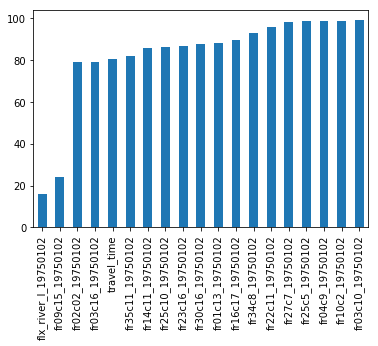

In [21]:
sc.get_forecast_summary().sort_values(by='percent_reduction').percent_reduction.plot(kind="bar")

In [22]:
df_full = sc_full.get_forecast_summary()
df_full.loc[:,"full"] = df_full.percent_reduction
df_full.loc[:,"diag"] = sc.get_forecast_summary().percent_reduction

2017-09-04 10:46:54.313707 starting: propagating prior to predictions
2017-09-04 10:46:54.314298 finished: propagating prior to predictions took: 0:00:00.000591
2017-09-04 10:46:54.314454 starting: propagating posterior to predictions
2017-09-04 10:46:54.315030 starting: Schur's complement
2017-09-04 10:46:54.315888 starting: xtqx
2017-09-04 10:46:55.282926 finished: xtqx took: 0:00:00.967038
2017-09-04 10:46:55.283692 finished: Schur's complement took: 0:00:00.968662
2017-09-04 10:46:55.284065 finished: propagating posterior to predictions took: 0:00:00.969611


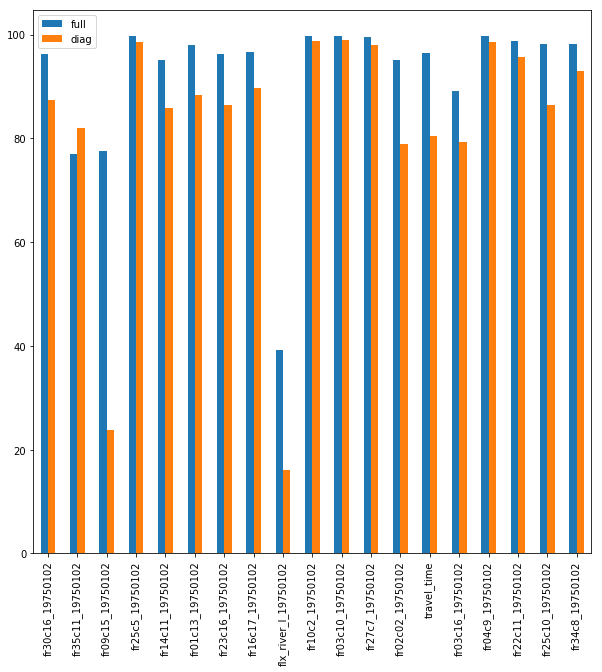

In [23]:
df_full.loc[:,["full","diag"]].plot(kind="bar",figsize=(10,10))

Why did percent reduction increase for all forecasts increase???

In [24]:
df_full.prior_var

fr30c16_19750102        4.671253e-01
fr35c11_19750102        2.174457e-01
fr09c15_19750102        1.761448e+00
fr25c5_19750102         1.284002e+01
fr14c11_19750102        4.973636e-01
fr01c13_19750102        5.866708e-01
fr23c16_19750102        4.143151e-01
fr16c17_19750102        5.287292e-01
flx_river_l_19750102    3.588064e+04
fr10c2_19750102         2.667926e+01
fr03c10_19750102        5.551148e+00
fr27c7_19750102         7.748982e+00
fr02c02_19750102        2.286964e+01
travel_time             4.817086e+08
fr03c16_19750102        1.457007e-01
fr04c9_19750102         7.433556e+00
fr22c11_19750102        1.368663e+00
fr25c10_19750102        2.777229e+00
fr34c8_19750102         2.019387e+00
Name: prior_var, dtype: float64

In [25]:
sc.get_forecast_summary().prior_var

fr30c16_19750102        1.643896e-01
fr35c11_19750102        2.807831e-01
fr09c15_19750102        8.293936e-01
fr25c5_19750102         2.467111e+00
fr14c11_19750102        2.175865e-01
fr01c13_19750102        1.821482e-01
fr23c16_19750102        1.457497e-01
fr16c17_19750102        2.054365e-01
flx_river_l_19750102    2.658455e+04
fr10c2_19750102         4.315919e+00
fr03c10_19750102        1.657727e+00
fr27c7_19750102         1.714796e+00
fr02c02_19750102        4.290913e+00
travel_time             1.145500e+08
fr03c16_19750102        1.018189e-01
fr04c9_19750102         1.991567e+00
fr22c11_19750102        4.639616e-01
fr25c10_19750102        8.735573e-01
fr34c8_19750102         6.091176e-01
Name: prior_var, dtype: float64

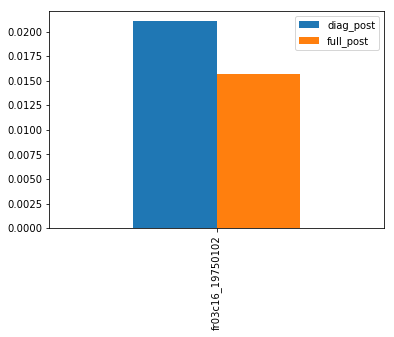

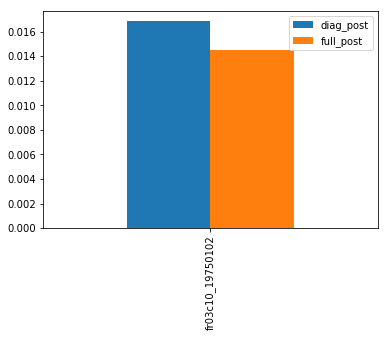

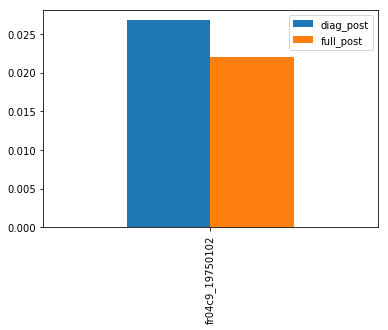

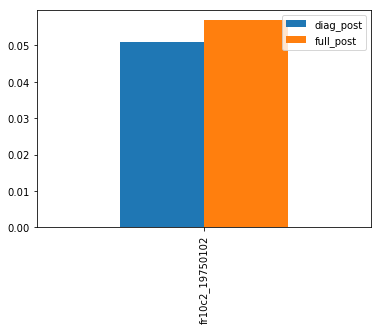

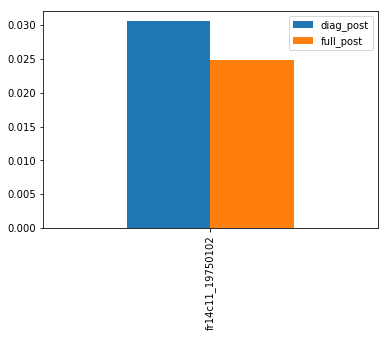

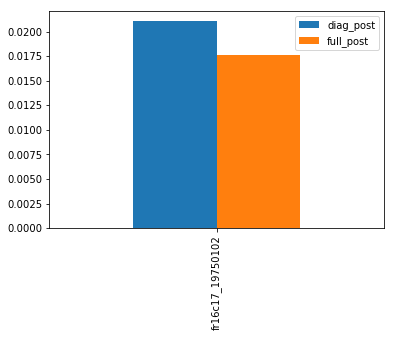

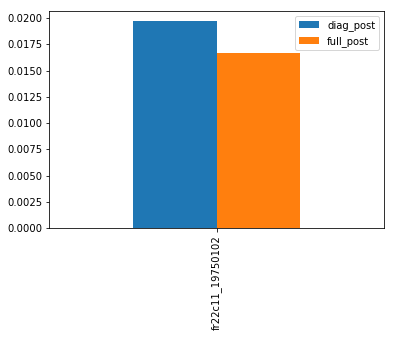

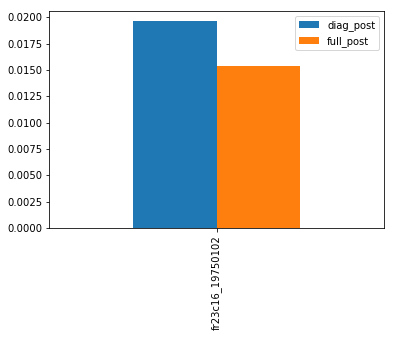

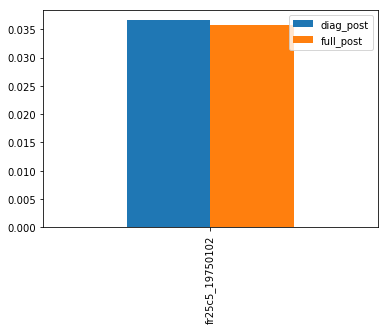

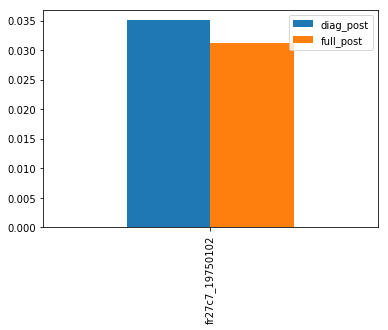

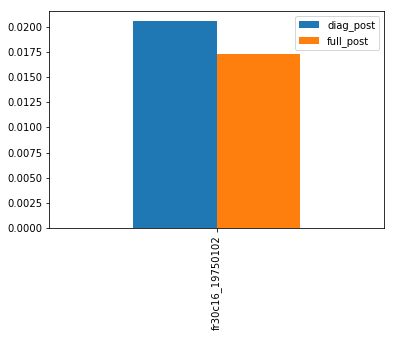

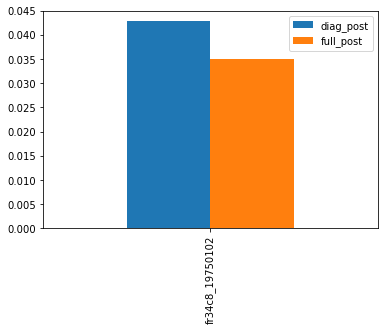

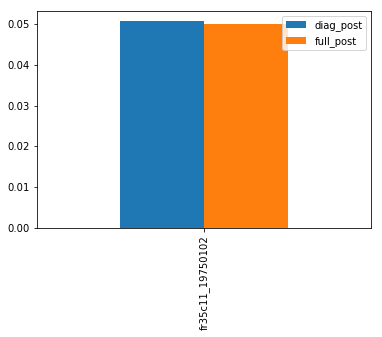

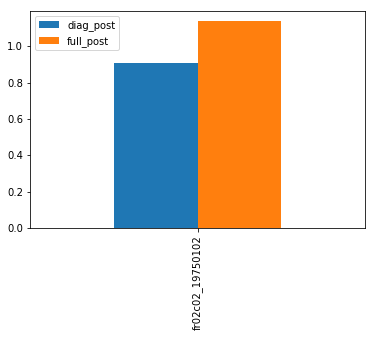

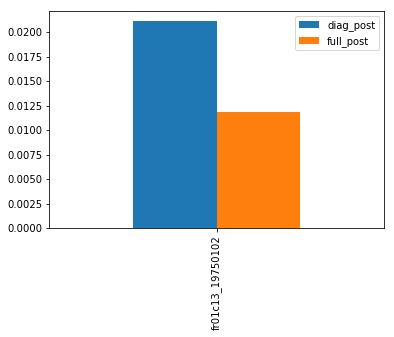

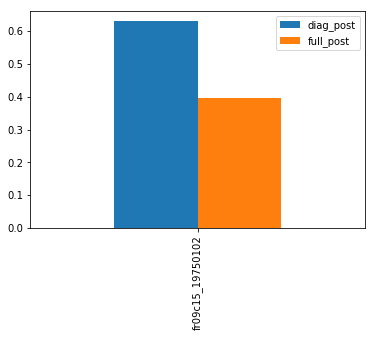

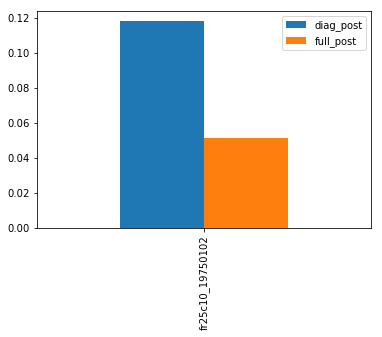

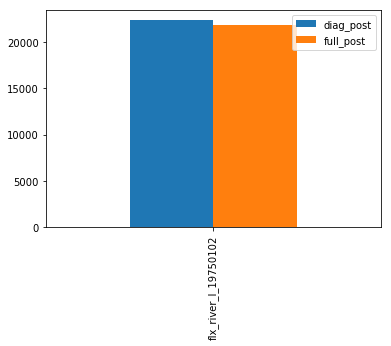

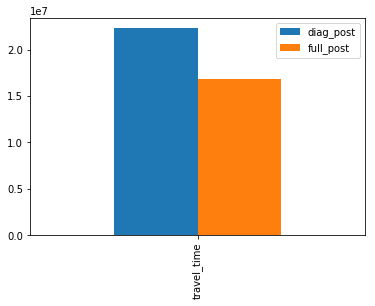

In [26]:
df_full.loc[:,"diag_post"] = sc.get_forecast_summary().post_var
df_full.loc[:,"full_post"] = df_full.post_var
for forecast in pst.forecast_names:
    df_full.loc[[forecast],["diag_post","full_post"]].plot(kind="bar")

Let's recalculate the value of possible new observations...this takes longer now that we are using a full covaraince matrix because the repeated matrix-matrix products...

In [27]:
df_full = sc_full.get_added_obs_importance(obslist_dict={oname:oname for oname in pobs_names},
                                base_obslist=sc.pst.nnz_obs_names,reset_zero_weight=True)

2017-09-04 10:46:58.368768 resetting zero weights to 1.0
2017-09-04 10:46:58.653830 starting: resetting zero weight obs in base_obslist
2017-09-04 10:46:58.664854 finished: resetting zero weight obs in base_obslist took: 0:00:00.011024
2017-09-04 10:46:58.664959 starting: resetting zero weight obs in pr04c01_19700101
2017-09-04 10:46:58.675714 finished: resetting zero weight obs in pr04c01_19700101 took: 0:00:00.010755
2017-09-04 10:46:58.675796 starting: resetting zero weight obs in pr31c07_19750101
2017-09-04 10:46:58.685679 finished: resetting zero weight obs in pr31c07_19750101 took: 0:00:00.009883
2017-09-04 10:46:58.685757 starting: resetting zero weight obs in pr26c07_19700102
2017-09-04 10:46:58.696081 finished: resetting zero weight obs in pr26c07_19700102 took: 0:00:00.010324
2017-09-04 10:46:58.696155 starting: resetting zero weight obs in pr19c11_19700102
2017-09-04 10:46:58.706037 finished: resetting zero weight obs in pr19c11_19700102 took: 0:00:00.009882
2017-09-04 10:46

2017-09-04 10:46:59.424325 finished: resetting zero weight obs in pr02c06_19700102 took: 0:00:00.012931
2017-09-04 10:46:59.424405 starting: resetting zero weight obs in pr13c11_19700102
2017-09-04 10:46:59.437945 finished: resetting zero weight obs in pr13c11_19700102 took: 0:00:00.013540
2017-09-04 10:46:59.438047 starting: resetting zero weight obs in pr38c06_19700101
2017-09-04 10:46:59.450484 finished: resetting zero weight obs in pr38c06_19700101 took: 0:00:00.012437
2017-09-04 10:46:59.450556 starting: resetting zero weight obs in pr26c13_19750102
2017-09-04 10:46:59.463683 finished: resetting zero weight obs in pr26c13_19750102 took: 0:00:00.013127
2017-09-04 10:46:59.463776 starting: resetting zero weight obs in pr37c17_19700101
2017-09-04 10:46:59.476655 finished: resetting zero weight obs in pr37c17_19700101 took: 0:00:00.012879
2017-09-04 10:46:59.476760 starting: resetting zero weight obs in pr23c07_19750102
2017-09-04 10:46:59.489595 finished: resetting zero weight obs in

2017-09-04 10:47:00.060721 finished: resetting zero weight obs in pr19c01_19700102 took: 0:00:00.014567
2017-09-04 10:47:00.060874 starting: resetting zero weight obs in pr15c08_19750102
2017-09-04 10:47:00.075232 finished: resetting zero weight obs in pr15c08_19750102 took: 0:00:00.014358
2017-09-04 10:47:00.075339 starting: resetting zero weight obs in pr30c06_19700102
2017-09-04 10:47:00.089681 finished: resetting zero weight obs in pr30c06_19700102 took: 0:00:00.014342
2017-09-04 10:47:00.089779 starting: resetting zero weight obs in pr12c14_19750102
2017-09-04 10:47:00.104868 finished: resetting zero weight obs in pr12c14_19750102 took: 0:00:00.015089
2017-09-04 10:47:00.104961 starting: resetting zero weight obs in pr35c11_19750101
2017-09-04 10:47:00.119036 finished: resetting zero weight obs in pr35c11_19750101 took: 0:00:00.014075
2017-09-04 10:47:00.119134 starting: resetting zero weight obs in pr21c15_19700102
2017-09-04 10:47:00.134254 finished: resetting zero weight obs in

2017-09-04 10:47:00.919049 finished: resetting zero weight obs in pr14c17_19750102 took: 0:00:00.016926
2017-09-04 10:47:00.919230 starting: resetting zero weight obs in pr01c11_19700101
2017-09-04 10:47:00.936598 finished: resetting zero weight obs in pr01c11_19700101 took: 0:00:00.017368
2017-09-04 10:47:00.936672 starting: resetting zero weight obs in pr12c17_19700101
2017-09-04 10:47:00.952534 finished: resetting zero weight obs in pr12c17_19700101 took: 0:00:00.015862
2017-09-04 10:47:00.952612 starting: resetting zero weight obs in pr16c01_19750101
2017-09-04 10:47:00.968757 finished: resetting zero weight obs in pr16c01_19750101 took: 0:00:00.016145
2017-09-04 10:47:00.968856 starting: resetting zero weight obs in pr19c16_19700102
2017-09-04 10:47:00.985583 finished: resetting zero weight obs in pr19c16_19700102 took: 0:00:00.016727
2017-09-04 10:47:00.985693 starting: resetting zero weight obs in pr36c16_19750101
2017-09-04 10:47:01.002158 finished: resetting zero weight obs in

2017-09-04 10:47:01.790052 finished: resetting zero weight obs in pr11c12_19700101 took: 0:00:00.017631
2017-09-04 10:47:01.790228 starting: resetting zero weight obs in pr14c08_19750102
2017-09-04 10:47:01.806834 finished: resetting zero weight obs in pr14c08_19750102 took: 0:00:00.016606
2017-09-04 10:47:01.806933 starting: resetting zero weight obs in pr03c02_19750101
2017-09-04 10:47:01.821823 finished: resetting zero weight obs in pr03c02_19750101 took: 0:00:00.014890
2017-09-04 10:47:01.821891 starting: resetting zero weight obs in pr24c13_19700101
2017-09-04 10:47:01.836360 finished: resetting zero weight obs in pr24c13_19700101 took: 0:00:00.014469
2017-09-04 10:47:01.836439 starting: resetting zero weight obs in pr38c09_19700102
2017-09-04 10:47:01.851992 finished: resetting zero weight obs in pr38c09_19700102 took: 0:00:00.015553
2017-09-04 10:47:01.852113 starting: resetting zero weight obs in pr25c11_19700102
2017-09-04 10:47:01.870615 finished: resetting zero weight obs in

2017-09-04 10:47:02.675770 finished: resetting zero weight obs in pr27c08_19700101 took: 0:00:00.016563
2017-09-04 10:47:02.675998 starting: resetting zero weight obs in pr37c10_19750101
2017-09-04 10:47:02.693651 finished: resetting zero weight obs in pr37c10_19750101 took: 0:00:00.017653
2017-09-04 10:47:02.693738 starting: resetting zero weight obs in pr35c07_19750102
2017-09-04 10:47:02.709376 finished: resetting zero weight obs in pr35c07_19750102 took: 0:00:00.015638
2017-09-04 10:47:02.709461 starting: resetting zero weight obs in pr32c04_19750101
2017-09-04 10:47:02.724750 finished: resetting zero weight obs in pr32c04_19750101 took: 0:00:00.015289
2017-09-04 10:47:02.724819 starting: resetting zero weight obs in pr33c08_19750102
2017-09-04 10:47:02.740163 finished: resetting zero weight obs in pr33c08_19750102 took: 0:00:00.015344
2017-09-04 10:47:02.740238 starting: resetting zero weight obs in pr17c11_19750102
2017-09-04 10:47:02.755864 finished: resetting zero weight obs in

2017-09-04 10:47:03.518584 finished: resetting zero weight obs in pr25c16_19750102 took: 0:00:00.016945
2017-09-04 10:47:03.518731 starting: resetting zero weight obs in pr01c04_19700101
2017-09-04 10:47:03.535783 finished: resetting zero weight obs in pr01c04_19700101 took: 0:00:00.017052
2017-09-04 10:47:03.535879 starting: resetting zero weight obs in pr14c15_19750101
2017-09-04 10:47:03.553613 finished: resetting zero weight obs in pr14c15_19750101 took: 0:00:00.017734
2017-09-04 10:47:03.553689 starting: resetting zero weight obs in pr04c14_19750101
2017-09-04 10:47:03.568638 finished: resetting zero weight obs in pr04c14_19750101 took: 0:00:00.014949
2017-09-04 10:47:03.568713 starting: resetting zero weight obs in pr14c17_19700101
2017-09-04 10:47:03.584246 finished: resetting zero weight obs in pr14c17_19700101 took: 0:00:00.015533
2017-09-04 10:47:03.584311 starting: resetting zero weight obs in pr28c10_19700101
2017-09-04 10:47:03.602108 finished: resetting zero weight obs in

2017-09-04 10:47:04.407013 finished: resetting zero weight obs in pr05c01_19750101 took: 0:00:00.018278
2017-09-04 10:47:04.407125 starting: resetting zero weight obs in pr17c14_19700101
2017-09-04 10:47:04.425069 finished: resetting zero weight obs in pr17c14_19700101 took: 0:00:00.017944
2017-09-04 10:47:04.425155 starting: resetting zero weight obs in pr10c18_19700102
2017-09-04 10:47:04.444639 finished: resetting zero weight obs in pr10c18_19700102 took: 0:00:00.019484
2017-09-04 10:47:04.444720 starting: resetting zero weight obs in pr08c07_19750102
2017-09-04 10:47:04.460694 finished: resetting zero weight obs in pr08c07_19750102 took: 0:00:00.015974
2017-09-04 10:47:04.460762 starting: resetting zero weight obs in pr33c04_19700101
2017-09-04 10:47:04.477231 finished: resetting zero weight obs in pr33c04_19700101 took: 0:00:00.016469
2017-09-04 10:47:04.477301 starting: resetting zero weight obs in pr22c04_19700101
2017-09-04 10:47:04.493588 finished: resetting zero weight obs in

2017-09-04 10:47:05.242353 starting: resetting zero weight obs in pr16c01_19700101
2017-09-04 10:47:05.261331 finished: resetting zero weight obs in pr16c01_19700101 took: 0:00:00.018978
2017-09-04 10:47:05.261437 starting: resetting zero weight obs in pr20c15_19700102
2017-09-04 10:47:05.279809 finished: resetting zero weight obs in pr20c15_19700102 took: 0:00:00.018372
2017-09-04 10:47:05.279913 starting: resetting zero weight obs in pr06c09_19700101
2017-09-04 10:47:05.297935 finished: resetting zero weight obs in pr06c09_19700101 took: 0:00:00.018022
2017-09-04 10:47:05.298026 starting: resetting zero weight obs in pr15c17_19700102
2017-09-04 10:47:05.315941 finished: resetting zero weight obs in pr15c17_19700102 took: 0:00:00.017915
2017-09-04 10:47:05.316034 starting: resetting zero weight obs in pr24c18_19750101
2017-09-04 10:47:05.333414 finished: resetting zero weight obs in pr24c18_19750101 took: 0:00:00.017380
2017-09-04 10:47:05.333490 starting: resetting zero weight obs in

2017-09-04 10:47:06.135550 finished: resetting zero weight obs in pr04c05_19700101 took: 0:00:00.016617
2017-09-04 10:47:06.135834 starting: resetting zero weight obs in pr15c18_19750102
2017-09-04 10:47:06.157055 finished: resetting zero weight obs in pr15c18_19750102 took: 0:00:00.021221
2017-09-04 10:47:06.157162 starting: resetting zero weight obs in pr04c11_19700101
2017-09-04 10:47:06.174650 finished: resetting zero weight obs in pr04c11_19700101 took: 0:00:00.017488
2017-09-04 10:47:06.174732 starting: resetting zero weight obs in pr05c07_19750102
2017-09-04 10:47:06.192250 finished: resetting zero weight obs in pr05c07_19750102 took: 0:00:00.017518
2017-09-04 10:47:06.192321 starting: resetting zero weight obs in pr27c15_19750102
2017-09-04 10:47:06.210043 finished: resetting zero weight obs in pr27c15_19750102 took: 0:00:00.017722
2017-09-04 10:47:06.210122 starting: resetting zero weight obs in pr01c02_19750102
2017-09-04 10:47:06.226292 finished: resetting zero weight obs in

2017-09-04 10:47:07.000591 finished: resetting zero weight obs in pr15c16_19700101 took: 0:00:00.019690
2017-09-04 10:47:07.000750 starting: resetting zero weight obs in pr05c11_19700101
2017-09-04 10:47:07.018738 finished: resetting zero weight obs in pr05c11_19700101 took: 0:00:00.017988
2017-09-04 10:47:07.018836 starting: resetting zero weight obs in pr02c02_19750101
2017-09-04 10:47:07.036984 finished: resetting zero weight obs in pr02c02_19750101 took: 0:00:00.018148
2017-09-04 10:47:07.037074 starting: resetting zero weight obs in pr32c09_19700102
2017-09-04 10:47:07.054126 finished: resetting zero weight obs in pr32c09_19700102 took: 0:00:00.017052
2017-09-04 10:47:07.054197 starting: resetting zero weight obs in pr25c17_19750102
2017-09-04 10:47:07.071365 finished: resetting zero weight obs in pr25c17_19750102 took: 0:00:00.017168
2017-09-04 10:47:07.071458 starting: resetting zero weight obs in pr23c02_19750101
2017-09-04 10:47:07.089094 finished: resetting zero weight obs in

2017-09-04 10:47:07.890333 finished: resetting zero weight obs in pr13c15_19700101 took: 0:00:00.018640
2017-09-04 10:47:07.890672 starting: resetting zero weight obs in pr07c08_19700102
2017-09-04 10:47:07.909540 finished: resetting zero weight obs in pr07c08_19700102 took: 0:00:00.018868
2017-09-04 10:47:07.909627 starting: resetting zero weight obs in pr28c08_19750102
2017-09-04 10:47:07.930545 finished: resetting zero weight obs in pr28c08_19750102 took: 0:00:00.020918
2017-09-04 10:47:07.930619 starting: resetting zero weight obs in pr07c18_19700101
2017-09-04 10:47:07.948607 finished: resetting zero weight obs in pr07c18_19700101 took: 0:00:00.017988
2017-09-04 10:47:07.948700 starting: resetting zero weight obs in pr24c07_19700102
2017-09-04 10:47:07.968929 finished: resetting zero weight obs in pr24c07_19700102 took: 0:00:00.020229
2017-09-04 10:47:07.969007 starting: resetting zero weight obs in pr20c16_19700101
2017-09-04 10:47:07.986737 finished: resetting zero weight obs in

2017-09-04 10:47:08.765942 starting: resetting zero weight obs in pr38c09_19750101
2017-09-04 10:47:08.785616 finished: resetting zero weight obs in pr38c09_19750101 took: 0:00:00.019674
2017-09-04 10:47:08.785909 starting: resetting zero weight obs in pr32c01_19750102
2017-09-04 10:47:08.805688 finished: resetting zero weight obs in pr32c01_19750102 took: 0:00:00.019779
2017-09-04 10:47:08.805819 starting: resetting zero weight obs in pr06c05_19750102
2017-09-04 10:47:08.824906 finished: resetting zero weight obs in pr06c05_19750102 took: 0:00:00.019087
2017-09-04 10:47:08.825005 starting: resetting zero weight obs in pr19c10_19700102
2017-09-04 10:47:08.844157 finished: resetting zero weight obs in pr19c10_19700102 took: 0:00:00.019152
2017-09-04 10:47:08.844248 starting: resetting zero weight obs in pr33c06_19700101
2017-09-04 10:47:08.862813 finished: resetting zero weight obs in pr33c06_19700101 took: 0:00:00.018565
2017-09-04 10:47:08.862896 starting: resetting zero weight obs in

2017-09-04 10:47:09.679761 finished: resetting zero weight obs in pr24c09_19700102 took: 0:00:00.022168
2017-09-04 10:47:09.679842 starting: resetting zero weight obs in pr38c16_19700102
2017-09-04 10:47:09.700274 finished: resetting zero weight obs in pr38c16_19700102 took: 0:00:00.020432
2017-09-04 10:47:09.700370 starting: resetting zero weight obs in pr38c07_19700101
2017-09-04 10:47:09.719424 finished: resetting zero weight obs in pr38c07_19700101 took: 0:00:00.019054
2017-09-04 10:47:09.719508 starting: resetting zero weight obs in pr30c01_19750102
2017-09-04 10:47:09.739865 finished: resetting zero weight obs in pr30c01_19750102 took: 0:00:00.020357
2017-09-04 10:47:09.739954 starting: resetting zero weight obs in pr32c08_19700102
2017-09-04 10:47:09.758194 finished: resetting zero weight obs in pr32c08_19700102 took: 0:00:00.018240
2017-09-04 10:47:09.758262 starting: resetting zero weight obs in pr07c12_19750101
2017-09-04 10:47:09.776478 finished: resetting zero weight obs in

2017-09-04 10:47:10.543062 finished: resetting zero weight obs in pr26c16_19700101 took: 0:00:00.019625
2017-09-04 10:47:10.543437 starting: resetting zero weight obs in pr26c09_19750102
2017-09-04 10:47:10.564424 finished: resetting zero weight obs in pr26c09_19750102 took: 0:00:00.020987
2017-09-04 10:47:10.564543 starting: resetting zero weight obs in pr28c13_19700101
2017-09-04 10:47:10.583421 finished: resetting zero weight obs in pr28c13_19700101 took: 0:00:00.018878
2017-09-04 10:47:10.583509 starting: resetting zero weight obs in pr03c01_19750101
2017-09-04 10:47:10.603211 finished: resetting zero weight obs in pr03c01_19750101 took: 0:00:00.019702
2017-09-04 10:47:10.603296 starting: resetting zero weight obs in pr20c15_19700101
2017-09-04 10:47:10.622143 finished: resetting zero weight obs in pr20c15_19700101 took: 0:00:00.018847
2017-09-04 10:47:10.622252 starting: resetting zero weight obs in pr04c04_19750101
2017-09-04 10:47:10.641716 finished: resetting zero weight obs in

2017-09-04 10:47:11.424459 finished: resetting zero weight obs in pr33c13_19700101 took: 0:00:00.022705
2017-09-04 10:47:11.424619 starting: resetting zero weight obs in pr23c16_19750101
2017-09-04 10:47:11.446359 finished: resetting zero weight obs in pr23c16_19750101 took: 0:00:00.021740
2017-09-04 10:47:11.446477 starting: resetting zero weight obs in pr30c10_19750102
2017-09-04 10:47:11.466093 finished: resetting zero weight obs in pr30c10_19750102 took: 0:00:00.019616
2017-09-04 10:47:11.466178 starting: resetting zero weight obs in pr35c07_19700101
2017-09-04 10:47:11.488444 finished: resetting zero weight obs in pr35c07_19700101 took: 0:00:00.022266
2017-09-04 10:47:11.488544 starting: resetting zero weight obs in pr17c17_19700101
2017-09-04 10:47:11.508348 finished: resetting zero weight obs in pr17c17_19700101 took: 0:00:00.019804
2017-09-04 10:47:11.508567 starting: resetting zero weight obs in pr28c13_19750102
2017-09-04 10:47:11.531519 finished: resetting zero weight obs in

2017-09-04 10:47:12.536518 starting: resetting zero weight obs in pr32c13_19700102
2017-09-04 10:47:12.558673 finished: resetting zero weight obs in pr32c13_19700102 took: 0:00:00.022155
2017-09-04 10:47:12.558915 starting: resetting zero weight obs in pr23c07_19750101
2017-09-04 10:47:12.581672 finished: resetting zero weight obs in pr23c07_19750101 took: 0:00:00.022757
2017-09-04 10:47:12.581783 starting: resetting zero weight obs in pr29c14_19750101
2017-09-04 10:47:12.605941 finished: resetting zero weight obs in pr29c14_19750101 took: 0:00:00.024158
2017-09-04 10:47:12.606030 starting: resetting zero weight obs in pr29c06_19700101
2017-09-04 10:47:12.625814 finished: resetting zero weight obs in pr29c06_19700101 took: 0:00:00.019784
2017-09-04 10:47:12.625920 starting: resetting zero weight obs in pr28c09_19700102
2017-09-04 10:47:12.645522 finished: resetting zero weight obs in pr28c09_19700102 took: 0:00:00.019602
2017-09-04 10:47:12.645618 starting: resetting zero weight obs in

2017-09-04 10:47:13.651809 finished: resetting zero weight obs in pr24c06_19700102 took: 0:00:00.021337
2017-09-04 10:47:13.651914 starting: resetting zero weight obs in pr32c12_19700102
2017-09-04 10:47:13.675155 finished: resetting zero weight obs in pr32c12_19700102 took: 0:00:00.023241
2017-09-04 10:47:13.675252 starting: resetting zero weight obs in pr03c16_19750101
2017-09-04 10:47:13.695517 finished: resetting zero weight obs in pr03c16_19750101 took: 0:00:00.020265
2017-09-04 10:47:13.695610 starting: resetting zero weight obs in pr28c11_19700101
2017-09-04 10:47:13.716657 finished: resetting zero weight obs in pr28c11_19700101 took: 0:00:00.021047
2017-09-04 10:47:13.716751 starting: resetting zero weight obs in pr31c18_19750101
2017-09-04 10:47:13.739663 finished: resetting zero weight obs in pr31c18_19750101 took: 0:00:00.022912
2017-09-04 10:47:13.739766 starting: resetting zero weight obs in pr13c13_19700102
2017-09-04 10:47:13.760918 finished: resetting zero weight obs in

2017-09-04 10:47:14.766925 starting: resetting zero weight obs in pr31c04_19700102
2017-09-04 10:47:14.792313 finished: resetting zero weight obs in pr31c04_19700102 took: 0:00:00.025388
2017-09-04 10:47:14.792415 starting: resetting zero weight obs in pr20c12_19750101
2017-09-04 10:47:14.814045 finished: resetting zero weight obs in pr20c12_19750101 took: 0:00:00.021630
2017-09-04 10:47:14.814140 starting: resetting zero weight obs in pr15c15_19750101
2017-09-04 10:47:14.835185 finished: resetting zero weight obs in pr15c15_19750101 took: 0:00:00.021045
2017-09-04 10:47:14.835285 starting: resetting zero weight obs in pr33c13_19750102
2017-09-04 10:47:14.857803 finished: resetting zero weight obs in pr33c13_19750102 took: 0:00:00.022518
2017-09-04 10:47:14.857919 starting: resetting zero weight obs in pr22c17_19700101
2017-09-04 10:47:14.879803 finished: resetting zero weight obs in pr22c17_19700101 took: 0:00:00.021884
2017-09-04 10:47:14.879903 starting: resetting zero weight obs in

2017-09-04 10:47:15.941672 finished: resetting zero weight obs in pr38c06_19750102 took: 0:00:00.021194
2017-09-04 10:47:15.941766 starting: resetting zero weight obs in pr13c12_19700101
2017-09-04 10:47:15.962996 finished: resetting zero weight obs in pr13c12_19700101 took: 0:00:00.021230
2017-09-04 10:47:15.963082 starting: resetting zero weight obs in pr25c18_19700102
2017-09-04 10:47:15.983187 finished: resetting zero weight obs in pr25c18_19700102 took: 0:00:00.020105
2017-09-04 10:47:15.983273 starting: resetting zero weight obs in pr01c09_19700102
2017-09-04 10:47:16.003212 finished: resetting zero weight obs in pr01c09_19700102 took: 0:00:00.019939
2017-09-04 10:47:16.003318 starting: resetting zero weight obs in pr27c14_19700102
2017-09-04 10:47:16.024875 finished: resetting zero weight obs in pr27c14_19700102 took: 0:00:00.021557
2017-09-04 10:47:16.024962 starting: resetting zero weight obs in pr22c02_19700101
2017-09-04 10:47:16.045959 finished: resetting zero weight obs in

2017-09-04 10:47:17.030993 finished: resetting zero weight obs in pr33c03_19750101 took: 0:00:00.022465
2017-09-04 10:47:17.031099 starting: resetting zero weight obs in pr16c16_19700101
2017-09-04 10:47:17.054814 finished: resetting zero weight obs in pr16c16_19700101 took: 0:00:00.023715
2017-09-04 10:47:17.054978 starting: resetting zero weight obs in pr01c07_19750101
2017-09-04 10:47:17.078961 finished: resetting zero weight obs in pr01c07_19750101 took: 0:00:00.023983
2017-09-04 10:47:17.079051 starting: resetting zero weight obs in pr33c09_19750102
2017-09-04 10:47:17.101171 finished: resetting zero weight obs in pr33c09_19750102 took: 0:00:00.022120
2017-09-04 10:47:17.101259 starting: resetting zero weight obs in pr24c10_19750101
2017-09-04 10:47:17.124165 finished: resetting zero weight obs in pr24c10_19750101 took: 0:00:00.022906
2017-09-04 10:47:17.124264 starting: resetting zero weight obs in pr05c01_19700102
2017-09-04 10:47:17.146875 finished: resetting zero weight obs in

2017-09-04 10:47:18.090324 finished: resetting zero weight obs in pr27c11_19700102 took: 0:00:00.023169
2017-09-04 10:47:18.090410 starting: resetting zero weight obs in pr16c09_19700102
2017-09-04 10:47:18.113595 finished: resetting zero weight obs in pr16c09_19700102 took: 0:00:00.023185
2017-09-04 10:47:18.113692 starting: resetting zero weight obs in pr09c08_19750102
2017-09-04 10:47:18.135805 finished: resetting zero weight obs in pr09c08_19750102 took: 0:00:00.022113
2017-09-04 10:47:18.135913 starting: resetting zero weight obs in pr33c04_19750101
2017-09-04 10:47:18.158399 finished: resetting zero weight obs in pr33c04_19750101 took: 0:00:00.022486
2017-09-04 10:47:18.158503 starting: resetting zero weight obs in pr01c18_19750101
2017-09-04 10:47:18.180429 finished: resetting zero weight obs in pr01c18_19750101 took: 0:00:00.021926
2017-09-04 10:47:18.180529 starting: resetting zero weight obs in pr33c17_19700102
2017-09-04 10:47:18.203367 finished: resetting zero weight obs in

2017-09-04 10:47:19.210347 finished: resetting zero weight obs in pr02c13_19700102 took: 0:00:00.026327
2017-09-04 10:47:19.210444 starting: resetting zero weight obs in pr25c17_19700102
2017-09-04 10:47:19.233754 finished: resetting zero weight obs in pr25c17_19700102 took: 0:00:00.023310
2017-09-04 10:47:19.233861 starting: resetting zero weight obs in pr22c17_19750101
2017-09-04 10:47:19.256778 finished: resetting zero weight obs in pr22c17_19750101 took: 0:00:00.022917
2017-09-04 10:47:19.256871 starting: resetting zero weight obs in pr01c09_19750101
2017-09-04 10:47:19.277639 finished: resetting zero weight obs in pr01c09_19750101 took: 0:00:00.020768
2017-09-04 10:47:19.277721 starting: resetting zero weight obs in pr24c16_19700101
2017-09-04 10:47:19.298907 finished: resetting zero weight obs in pr24c16_19700101 took: 0:00:00.021186
2017-09-04 10:47:19.298989 starting: resetting zero weight obs in pr28c01_19700102
2017-09-04 10:47:19.319862 finished: resetting zero weight obs in

2017-09-04 10:47:20.325248 starting: resetting zero weight obs in pr38c13_19750102
2017-09-04 10:47:20.348920 finished: resetting zero weight obs in pr38c13_19750102 took: 0:00:00.023672
2017-09-04 10:47:20.349019 starting: resetting zero weight obs in pr37c09_19750102
2017-09-04 10:47:20.372613 finished: resetting zero weight obs in pr37c09_19750102 took: 0:00:00.023594
2017-09-04 10:47:20.372702 starting: resetting zero weight obs in pr07c02_19750102
2017-09-04 10:47:20.395937 finished: resetting zero weight obs in pr07c02_19750102 took: 0:00:00.023235
2017-09-04 10:47:20.396023 starting: resetting zero weight obs in pr25c16_19750101
2017-09-04 10:47:20.419840 finished: resetting zero weight obs in pr25c16_19750101 took: 0:00:00.023817
2017-09-04 10:47:20.419927 starting: resetting zero weight obs in pr02c09_19750102
2017-09-04 10:47:20.441870 finished: resetting zero weight obs in pr02c09_19750102 took: 0:00:00.021943
2017-09-04 10:47:20.441955 starting: resetting zero weight obs in

2017-09-04 10:47:21.459674 starting: resetting zero weight obs in pr35c16_19750102
2017-09-04 10:47:21.484416 finished: resetting zero weight obs in pr35c16_19750102 took: 0:00:00.024742
2017-09-04 10:47:21.484855 starting: resetting zero weight obs in pr36c15_19750101
2017-09-04 10:47:21.509038 finished: resetting zero weight obs in pr36c15_19750101 took: 0:00:00.024183
2017-09-04 10:47:21.509131 starting: resetting zero weight obs in pr37c09_19700101
2017-09-04 10:47:21.532311 finished: resetting zero weight obs in pr37c09_19700101 took: 0:00:00.023180
2017-09-04 10:47:21.532399 starting: resetting zero weight obs in pr06c03_19700101
2017-09-04 10:47:21.556333 finished: resetting zero weight obs in pr06c03_19700101 took: 0:00:00.023934
2017-09-04 10:47:21.556433 starting: resetting zero weight obs in pr04c13_19750101
2017-09-04 10:47:21.579852 finished: resetting zero weight obs in pr04c13_19750101 took: 0:00:00.023419
2017-09-04 10:47:21.579963 starting: resetting zero weight obs in

2017-09-04 10:47:22.573330 starting: resetting zero weight obs in pr31c05_19750101
2017-09-04 10:47:22.598271 finished: resetting zero weight obs in pr31c05_19750101 took: 0:00:00.024941
2017-09-04 10:47:22.598375 starting: resetting zero weight obs in pr28c18_19750101
2017-09-04 10:47:22.623869 finished: resetting zero weight obs in pr28c18_19750101 took: 0:00:00.025494
2017-09-04 10:47:22.623962 starting: resetting zero weight obs in pr06c18_19700102
2017-09-04 10:47:22.647279 finished: resetting zero weight obs in pr06c18_19700102 took: 0:00:00.023317
2017-09-04 10:47:22.647374 starting: resetting zero weight obs in pr26c07_19700101
2017-09-04 10:47:22.670348 finished: resetting zero weight obs in pr26c07_19700101 took: 0:00:00.022974
2017-09-04 10:47:22.670447 starting: resetting zero weight obs in pr15c01_19700102
2017-09-04 10:47:22.693964 finished: resetting zero weight obs in pr15c01_19700102 took: 0:00:00.023517
2017-09-04 10:47:22.694071 starting: resetting zero weight obs in

2017-09-04 10:47:23.723995 starting: resetting zero weight obs in pr25c09_19750102
2017-09-04 10:47:23.749799 finished: resetting zero weight obs in pr25c09_19750102 took: 0:00:00.025804
2017-09-04 10:47:23.750086 starting: resetting zero weight obs in pr10c11_19700101
2017-09-04 10:47:23.776360 finished: resetting zero weight obs in pr10c11_19700101 took: 0:00:00.026274
2017-09-04 10:47:23.776468 starting: resetting zero weight obs in pr33c18_19750101
2017-09-04 10:47:23.801358 finished: resetting zero weight obs in pr33c18_19750101 took: 0:00:00.024890
2017-09-04 10:47:23.801450 starting: resetting zero weight obs in pr13c12_19750101
2017-09-04 10:47:23.825999 finished: resetting zero weight obs in pr13c12_19750101 took: 0:00:00.024549
2017-09-04 10:47:23.826093 starting: resetting zero weight obs in pr24c08_19700102
2017-09-04 10:47:23.850180 finished: resetting zero weight obs in pr24c08_19700102 took: 0:00:00.024087
2017-09-04 10:47:23.850275 starting: resetting zero weight obs in

2017-09-04 10:47:24.861490 finished: resetting zero weight obs in pr04c13_19700101 took: 0:00:00.029134
2017-09-04 10:47:24.861787 starting: resetting zero weight obs in pr01c16_19700102
2017-09-04 10:47:24.886912 finished: resetting zero weight obs in pr01c16_19700102 took: 0:00:00.025125
2017-09-04 10:47:24.887033 starting: resetting zero weight obs in pr02c17_19750101
2017-09-04 10:47:24.913912 finished: resetting zero weight obs in pr02c17_19750101 took: 0:00:00.026879
2017-09-04 10:47:24.914005 starting: resetting zero weight obs in pr06c04_19700102
2017-09-04 10:47:24.937975 finished: resetting zero weight obs in pr06c04_19700102 took: 0:00:00.023970
2017-09-04 10:47:24.938076 starting: resetting zero weight obs in pr17c17_19750101
2017-09-04 10:47:24.962375 finished: resetting zero weight obs in pr17c17_19750101 took: 0:00:00.024299
2017-09-04 10:47:24.962469 starting: resetting zero weight obs in pr03c02_19700101
2017-09-04 10:47:24.985514 finished: resetting zero weight obs in

2017-09-04 10:47:25.954412 finished: resetting zero weight obs in pr34c07_19750101 took: 0:00:00.027877
2017-09-04 10:47:25.954644 starting: resetting zero weight obs in pr07c01_19700101
2017-09-04 10:47:25.983052 finished: resetting zero weight obs in pr07c01_19700101 took: 0:00:00.028408
2017-09-04 10:47:25.983157 starting: resetting zero weight obs in pr21c11_19750101
2017-09-04 10:47:26.011418 finished: resetting zero weight obs in pr21c11_19750101 took: 0:00:00.028261
2017-09-04 10:47:26.011505 starting: resetting zero weight obs in pr12c16_19700102
2017-09-04 10:47:26.035354 finished: resetting zero weight obs in pr12c16_19700102 took: 0:00:00.023849
2017-09-04 10:47:26.035465 starting: resetting zero weight obs in pr01c16_19750101
2017-09-04 10:47:26.060562 finished: resetting zero weight obs in pr01c16_19750101 took: 0:00:00.025097
2017-09-04 10:47:26.060656 starting: resetting zero weight obs in pr05c07_19700102
2017-09-04 10:47:26.086471 finished: resetting zero weight obs in

2017-09-04 10:47:27.230971 starting: resetting zero weight obs in pr12c18_19750102
2017-09-04 10:47:27.256675 finished: resetting zero weight obs in pr12c18_19750102 took: 0:00:00.025704
2017-09-04 10:47:27.257039 starting: resetting zero weight obs in pr11c11_19750101
2017-09-04 10:47:27.283236 finished: resetting zero weight obs in pr11c11_19750101 took: 0:00:00.026197
2017-09-04 10:47:27.283330 starting: resetting zero weight obs in pr06c14_19750101
2017-09-04 10:47:27.311857 finished: resetting zero weight obs in pr06c14_19750101 took: 0:00:00.028527
2017-09-04 10:47:27.311956 starting: resetting zero weight obs in pr24c11_19750102
2017-09-04 10:47:27.336795 finished: resetting zero weight obs in pr24c11_19750102 took: 0:00:00.024839
2017-09-04 10:47:27.336891 starting: resetting zero weight obs in pr09c02_19700101
2017-09-04 10:47:27.364134 finished: resetting zero weight obs in pr09c02_19700101 took: 0:00:00.027243
2017-09-04 10:47:27.364239 starting: resetting zero weight obs in

2017-09-04 10:47:28.403870 finished: resetting zero weight obs in pr04c12_19750102 took: 0:00:00.027040
2017-09-04 10:47:28.404131 starting: resetting zero weight obs in pr24c02_19700102
2017-09-04 10:47:28.430819 finished: resetting zero weight obs in pr24c02_19700102 took: 0:00:00.026688
2017-09-04 10:47:28.430926 starting: resetting zero weight obs in pr18c17_19750101
2017-09-04 10:47:28.457757 finished: resetting zero weight obs in pr18c17_19750101 took: 0:00:00.026831
2017-09-04 10:47:28.457857 starting: resetting zero weight obs in pr20c12_19700102
2017-09-04 10:47:28.482915 finished: resetting zero weight obs in pr20c12_19700102 took: 0:00:00.025058
2017-09-04 10:47:28.482993 starting: resetting zero weight obs in pr28c09_19700101
2017-09-04 10:47:28.509329 finished: resetting zero weight obs in pr28c09_19700101 took: 0:00:00.026336
2017-09-04 10:47:28.509417 starting: resetting zero weight obs in pr28c04_19750102
2017-09-04 10:47:28.536873 finished: resetting zero weight obs in

2017-09-04 10:47:29.730203 finished: resetting zero weight obs in pr05c12_19700102 took: 0:00:00.025808
2017-09-04 10:47:29.730576 starting: resetting zero weight obs in pr21c15_19750102
2017-09-04 10:47:29.756451 finished: resetting zero weight obs in pr21c15_19750102 took: 0:00:00.025875
2017-09-04 10:47:29.756533 starting: resetting zero weight obs in pr34c07_19750102
2017-09-04 10:47:29.783082 finished: resetting zero weight obs in pr34c07_19750102 took: 0:00:00.026549
2017-09-04 10:47:29.783186 starting: resetting zero weight obs in pr27c06_19700102
2017-09-04 10:47:29.808705 finished: resetting zero weight obs in pr27c06_19700102 took: 0:00:00.025519
2017-09-04 10:47:29.808791 starting: resetting zero weight obs in pr36c11_19750101
2017-09-04 10:47:29.834434 finished: resetting zero weight obs in pr36c11_19750101 took: 0:00:00.025643
2017-09-04 10:47:29.834551 starting: resetting zero weight obs in pr21c06_19700101
2017-09-04 10:47:29.860812 finished: resetting zero weight obs in

2017-09-04 10:47:31.053189 starting: resetting zero weight obs in pr01c09_19750102
2017-09-04 10:47:31.079646 finished: resetting zero weight obs in pr01c09_19750102 took: 0:00:00.026457
2017-09-04 10:47:31.079766 starting: resetting zero weight obs in pr18c01_19750101
2017-09-04 10:47:31.105733 finished: resetting zero weight obs in pr18c01_19750101 took: 0:00:00.025967
2017-09-04 10:47:31.105853 starting: resetting zero weight obs in pr38c13_19700101
2017-09-04 10:47:31.132049 finished: resetting zero weight obs in pr38c13_19700101 took: 0:00:00.026196
2017-09-04 10:47:31.132143 starting: resetting zero weight obs in pr17c03_19700101
2017-09-04 10:47:31.156766 finished: resetting zero weight obs in pr17c03_19700101 took: 0:00:00.024623
2017-09-04 10:47:31.156875 starting: resetting zero weight obs in pr27c04_19750102
2017-09-04 10:47:31.183639 finished: resetting zero weight obs in pr27c04_19750102 took: 0:00:00.026764
2017-09-04 10:47:31.183741 starting: resetting zero weight obs in

2017-09-04 10:47:32.405612 finished: resetting zero weight obs in pr08c11_19700101 took: 0:00:00.026418
2017-09-04 10:47:32.405725 starting: resetting zero weight obs in pr25c13_19700101
2017-09-04 10:47:32.431111 finished: resetting zero weight obs in pr25c13_19700101 took: 0:00:00.025386
2017-09-04 10:47:32.431195 starting: resetting zero weight obs in pr25c01_19700102
2017-09-04 10:47:32.458617 finished: resetting zero weight obs in pr25c01_19700102 took: 0:00:00.027422
2017-09-04 10:47:32.458714 starting: resetting zero weight obs in pr06c04_19700101
2017-09-04 10:47:32.483409 finished: resetting zero weight obs in pr06c04_19700101 took: 0:00:00.024695
2017-09-04 10:47:32.483495 starting: resetting zero weight obs in pr31c17_19700102
2017-09-04 10:47:32.508390 finished: resetting zero weight obs in pr31c17_19700102 took: 0:00:00.024895
2017-09-04 10:47:32.508482 starting: resetting zero weight obs in pr01c17_19700101
2017-09-04 10:47:32.533028 finished: resetting zero weight obs in

2017-09-04 10:47:33.566542 finished: resetting zero weight obs in pr28c18_19750102 took: 0:00:00.030261
2017-09-04 10:47:33.566634 starting: resetting zero weight obs in pr13c13_19750101
2017-09-04 10:47:33.594219 finished: resetting zero weight obs in pr13c13_19750101 took: 0:00:00.027585
2017-09-04 10:47:33.594321 starting: resetting zero weight obs in pr05c05_19700101
2017-09-04 10:47:33.620440 finished: resetting zero weight obs in pr05c05_19700101 took: 0:00:00.026119
2017-09-04 10:47:33.620539 starting: resetting zero weight obs in pr12c16_19750101
2017-09-04 10:47:33.647880 finished: resetting zero weight obs in pr12c16_19750101 took: 0:00:00.027341
2017-09-04 10:47:33.647978 starting: resetting zero weight obs in pr23c06_19750102
2017-09-04 10:47:33.674783 finished: resetting zero weight obs in pr23c06_19750102 took: 0:00:00.026805
2017-09-04 10:47:33.674884 starting: resetting zero weight obs in pr01c12_19700102
2017-09-04 10:47:33.700440 finished: resetting zero weight obs in

2017-09-04 10:47:34.920351 finished: resetting zero weight obs in pr12c12_19700101 took: 0:00:00.025930
2017-09-04 10:47:34.920536 starting: resetting zero weight obs in pr30c17_19750101
2017-09-04 10:47:34.946802 finished: resetting zero weight obs in pr30c17_19750101 took: 0:00:00.026266
2017-09-04 10:47:34.946890 starting: resetting zero weight obs in pr16c13_19750101
2017-09-04 10:47:34.970908 finished: resetting zero weight obs in pr16c13_19750101 took: 0:00:00.024018
2017-09-04 10:47:34.970993 starting: resetting zero weight obs in pr04c11_19750102
2017-09-04 10:47:34.995762 finished: resetting zero weight obs in pr04c11_19750102 took: 0:00:00.024769
2017-09-04 10:47:34.995850 starting: resetting zero weight obs in pr36c06_19750102
2017-09-04 10:47:35.019621 finished: resetting zero weight obs in pr36c06_19750102 took: 0:00:00.023771
2017-09-04 10:47:35.019707 starting: resetting zero weight obs in pr20c18_19750101
2017-09-04 10:47:35.043891 finished: resetting zero weight obs in

2017-09-04 10:47:36.042115 starting: resetting zero weight obs in pr28c10_19700102
2017-09-04 10:47:36.069284 finished: resetting zero weight obs in pr28c10_19700102 took: 0:00:00.027169
2017-09-04 10:47:36.069510 starting: resetting zero weight obs in pr27c06_19700101
2017-09-04 10:47:36.097245 finished: resetting zero weight obs in pr27c06_19700101 took: 0:00:00.027735
2017-09-04 10:47:36.097368 starting: resetting zero weight obs in pr24c01_19700101
2017-09-04 10:47:36.124239 finished: resetting zero weight obs in pr24c01_19700101 took: 0:00:00.026871
2017-09-04 10:47:36.124494 starting: resetting zero weight obs in pr10c17_19750101
2017-09-04 10:47:36.151059 finished: resetting zero weight obs in pr10c17_19750101 took: 0:00:00.026565
2017-09-04 10:47:36.151164 starting: resetting zero weight obs in pr37c10_19750102
2017-09-04 10:47:36.176916 finished: resetting zero weight obs in pr37c10_19750102 took: 0:00:00.025752
2017-09-04 10:47:36.177034 starting: resetting zero weight obs in

2017-09-04 10:47:37.385211 finished: resetting zero weight obs in pr03c18_19700102 took: 0:00:00.026250
2017-09-04 10:47:37.385378 starting: resetting zero weight obs in pr26c04_19700101
2017-09-04 10:47:37.411150 finished: resetting zero weight obs in pr26c04_19700101 took: 0:00:00.025772
2017-09-04 10:47:37.411267 starting: resetting zero weight obs in pr02c08_19700102
2017-09-04 10:47:37.437216 finished: resetting zero weight obs in pr02c08_19700102 took: 0:00:00.025949
2017-09-04 10:47:37.437309 starting: resetting zero weight obs in pr27c09_19750102
2017-09-04 10:47:37.462737 finished: resetting zero weight obs in pr27c09_19750102 took: 0:00:00.025428
2017-09-04 10:47:37.462852 starting: resetting zero weight obs in pr36c18_19700102
2017-09-04 10:47:37.489297 finished: resetting zero weight obs in pr36c18_19700102 took: 0:00:00.026445
2017-09-04 10:47:37.489412 starting: resetting zero weight obs in pr32c18_19750101
2017-09-04 10:47:37.514936 finished: resetting zero weight obs in

2017-09-04 10:47:38.709601 starting: resetting zero weight obs in pr20c10_19750102
2017-09-04 10:47:38.735895 finished: resetting zero weight obs in pr20c10_19750102 took: 0:00:00.026294
2017-09-04 10:47:38.736003 starting: resetting zero weight obs in pr34c17_19750102
2017-09-04 10:47:38.761383 finished: resetting zero weight obs in pr34c17_19750102 took: 0:00:00.025380
2017-09-04 10:47:38.761489 starting: resetting zero weight obs in pr38c15_19700101
2017-09-04 10:47:38.788299 finished: resetting zero weight obs in pr38c15_19700101 took: 0:00:00.026810
2017-09-04 10:47:38.788387 starting: resetting zero weight obs in pr02c18_19750101
2017-09-04 10:47:38.813391 finished: resetting zero weight obs in pr02c18_19750101 took: 0:00:00.025004
2017-09-04 10:47:38.813482 starting: resetting zero weight obs in pr05c05_19750102
2017-09-04 10:47:38.837933 finished: resetting zero weight obs in pr05c05_19750102 took: 0:00:00.024451
2017-09-04 10:47:38.838032 starting: resetting zero weight obs in

2017-09-04 10:47:39.846945 starting: resetting zero weight obs in pr19c03_19700101
2017-09-04 10:47:39.872595 finished: resetting zero weight obs in pr19c03_19700101 took: 0:00:00.025650
2017-09-04 10:47:39.872941 starting: resetting zero weight obs in pr04c02_19700102
2017-09-04 10:47:39.900019 finished: resetting zero weight obs in pr04c02_19700102 took: 0:00:00.027078
2017-09-04 10:47:39.900117 starting: resetting zero weight obs in pr06c10_19700101
2017-09-04 10:47:39.925430 finished: resetting zero weight obs in pr06c10_19700101 took: 0:00:00.025313
2017-09-04 10:47:39.925540 starting: resetting zero weight obs in pr08c13_19750101
2017-09-04 10:47:39.952616 finished: resetting zero weight obs in pr08c13_19750101 took: 0:00:00.027076
2017-09-04 10:47:39.952720 starting: resetting zero weight obs in pr01c15_19750102
2017-09-04 10:47:39.978762 finished: resetting zero weight obs in pr01c15_19750102 took: 0:00:00.026042
2017-09-04 10:47:39.978856 starting: resetting zero weight obs in

2017-09-04 10:47:41.144574 finished: resetting zero weight obs in pr22c13_19750102 took: 0:00:00.027561
2017-09-04 10:47:41.145031 starting: resetting zero weight obs in pr38c13_19700102
2017-09-04 10:47:41.170481 finished: resetting zero weight obs in pr38c13_19700102 took: 0:00:00.025450
2017-09-04 10:47:41.170574 starting: resetting zero weight obs in pr27c16_19750102
2017-09-04 10:47:41.195576 finished: resetting zero weight obs in pr27c16_19750102 took: 0:00:00.025002
2017-09-04 10:47:41.195670 starting: resetting zero weight obs in pr02c06_19700101
2017-09-04 10:47:41.219350 finished: resetting zero weight obs in pr02c06_19700101 took: 0:00:00.023680
2017-09-04 10:47:41.219434 starting: resetting zero weight obs in pr26c10_19700101
2017-09-04 10:47:41.244190 finished: resetting zero weight obs in pr26c10_19700101 took: 0:00:00.024756
2017-09-04 10:47:41.244310 starting: resetting zero weight obs in pr06c12_19750102
2017-09-04 10:47:41.268915 finished: resetting zero weight obs in

2017-09-04 10:47:42.259093 finished: resetting zero weight obs in pr13c02_19700102 took: 0:00:00.026331
2017-09-04 10:47:42.259512 starting: resetting zero weight obs in pr13c18_19750102
2017-09-04 10:47:42.285367 finished: resetting zero weight obs in pr13c18_19750102 took: 0:00:00.025855
2017-09-04 10:47:42.285470 starting: resetting zero weight obs in pr24c07_19750102
2017-09-04 10:47:42.310369 finished: resetting zero weight obs in pr24c07_19750102 took: 0:00:00.024899
2017-09-04 10:47:42.310475 starting: resetting zero weight obs in pr21c02_19700101
2017-09-04 10:47:42.337048 finished: resetting zero weight obs in pr21c02_19700101 took: 0:00:00.026573
2017-09-04 10:47:42.337127 starting: resetting zero weight obs in pr21c02_19750101
2017-09-04 10:47:42.359662 finished: resetting zero weight obs in pr21c02_19750101 took: 0:00:00.022535
2017-09-04 10:47:42.359740 starting: resetting zero weight obs in pr20c11_19700101
2017-09-04 10:47:42.382580 finished: resetting zero weight obs in

2017-09-04 10:47:43.345669 finished: resetting zero weight obs in pr30c18_19700102 took: 0:00:00.025330
2017-09-04 10:47:43.345821 starting: resetting zero weight obs in pr05c07_19750101
2017-09-04 10:47:43.371659 finished: resetting zero weight obs in pr05c07_19750101 took: 0:00:00.025838
2017-09-04 10:47:43.371749 starting: resetting zero weight obs in pr04c09_19700102
2017-09-04 10:47:43.394965 finished: resetting zero weight obs in pr04c09_19700102 took: 0:00:00.023216
2017-09-04 10:47:43.395067 starting: resetting zero weight obs in pr25c16_19700101
2017-09-04 10:47:43.417568 finished: resetting zero weight obs in pr25c16_19700101 took: 0:00:00.022501
2017-09-04 10:47:43.417641 starting: resetting zero weight obs in pr11c16_19750101
2017-09-04 10:47:43.441107 finished: resetting zero weight obs in pr11c16_19750101 took: 0:00:00.023466
2017-09-04 10:47:43.441201 starting: resetting zero weight obs in pr16c13_19700101
2017-09-04 10:47:43.463856 finished: resetting zero weight obs in

2017-09-04 10:47:44.431517 starting: resetting zero weight obs in pr06c09_19750101
2017-09-04 10:47:44.455768 finished: resetting zero weight obs in pr06c09_19750101 took: 0:00:00.024251
2017-09-04 10:47:44.455881 starting: resetting zero weight obs in pr34c06_19750101
2017-09-04 10:47:44.480425 finished: resetting zero weight obs in pr34c06_19750101 took: 0:00:00.024544
2017-09-04 10:47:44.480514 starting: resetting zero weight obs in pr02c10_19700101
2017-09-04 10:47:44.504804 finished: resetting zero weight obs in pr02c10_19700101 took: 0:00:00.024290
2017-09-04 10:47:44.504895 starting: resetting zero weight obs in pr38c07_19750102
2017-09-04 10:47:44.527427 finished: resetting zero weight obs in pr38c07_19750102 took: 0:00:00.022532
2017-09-04 10:47:44.527508 starting: resetting zero weight obs in pr16c11_19750101
2017-09-04 10:47:44.549575 finished: resetting zero weight obs in pr16c11_19750101 took: 0:00:00.022067
2017-09-04 10:47:44.549656 starting: resetting zero weight obs in

2017-09-04 10:47:45.605366 starting: resetting zero weight obs in pr01c18_19750102
2017-09-04 10:47:45.627855 finished: resetting zero weight obs in pr01c18_19750102 took: 0:00:00.022489
2017-09-04 10:47:45.627954 starting: resetting zero weight obs in pr20c03_19750101
2017-09-04 10:47:45.650995 finished: resetting zero weight obs in pr20c03_19750101 took: 0:00:00.023041
2017-09-04 10:47:45.651097 starting: resetting zero weight obs in pr34c17_19700101
2017-09-04 10:47:45.673786 finished: resetting zero weight obs in pr34c17_19700101 took: 0:00:00.022689
2017-09-04 10:47:45.673868 starting: resetting zero weight obs in pr28c01_19750102
2017-09-04 10:47:45.695959 finished: resetting zero weight obs in pr28c01_19750102 took: 0:00:00.022091
2017-09-04 10:47:45.696044 starting: resetting zero weight obs in pr15c09_19700101
2017-09-04 10:47:45.720945 finished: resetting zero weight obs in pr15c09_19700101 took: 0:00:00.024901
2017-09-04 10:47:45.721023 starting: resetting zero weight obs in

2017-09-04 10:47:46.684534 starting: resetting zero weight obs in pr25c12_19700101
2017-09-04 10:47:46.707185 finished: resetting zero weight obs in pr25c12_19700101 took: 0:00:00.022651
2017-09-04 10:47:46.707388 starting: resetting zero weight obs in pr33c09_19700102
2017-09-04 10:47:46.729607 finished: resetting zero weight obs in pr33c09_19700102 took: 0:00:00.022219
2017-09-04 10:47:46.729707 starting: resetting zero weight obs in pr31c15_19750102
2017-09-04 10:47:46.752394 finished: resetting zero weight obs in pr31c15_19750102 took: 0:00:00.022687
2017-09-04 10:47:46.752484 starting: resetting zero weight obs in pr03c02_19750102
2017-09-04 10:47:46.775047 finished: resetting zero weight obs in pr03c02_19750102 took: 0:00:00.022563
2017-09-04 10:47:46.775141 starting: resetting zero weight obs in pr14c15_19750102
2017-09-04 10:47:46.797912 finished: resetting zero weight obs in pr14c15_19750102 took: 0:00:00.022771
2017-09-04 10:47:46.797994 starting: resetting zero weight obs in

2017-09-04 10:47:47.780866 starting: resetting zero weight obs in pr07c15_19750101
2017-09-04 10:47:47.803389 finished: resetting zero weight obs in pr07c15_19750101 took: 0:00:00.022523
2017-09-04 10:47:47.803725 starting: resetting zero weight obs in pr06c17_19700101
2017-09-04 10:47:47.824880 finished: resetting zero weight obs in pr06c17_19700101 took: 0:00:00.021155
2017-09-04 10:47:47.824985 starting: resetting zero weight obs in pr37c11_19700102
2017-09-04 10:47:47.846709 finished: resetting zero weight obs in pr37c11_19700102 took: 0:00:00.021724
2017-09-04 10:47:47.846828 starting: resetting zero weight obs in pr35c06_19700102
2017-09-04 10:47:47.868937 finished: resetting zero weight obs in pr35c06_19700102 took: 0:00:00.022109
2017-09-04 10:47:47.869031 starting: resetting zero weight obs in pr07c15_19750102
2017-09-04 10:47:47.889753 finished: resetting zero weight obs in pr07c15_19750102 took: 0:00:00.020722
2017-09-04 10:47:47.889848 starting: resetting zero weight obs in

2017-09-04 10:47:48.908466 finished: resetting zero weight obs in pr25c11_19750101 took: 0:00:00.024378
2017-09-04 10:47:48.908556 starting: resetting zero weight obs in pr04c09_19750101
2017-09-04 10:47:48.928543 finished: resetting zero weight obs in pr04c09_19750101 took: 0:00:00.019987
2017-09-04 10:47:48.928618 starting: resetting zero weight obs in pr14c09_19700101
2017-09-04 10:47:48.947680 finished: resetting zero weight obs in pr14c09_19700101 took: 0:00:00.019062
2017-09-04 10:47:48.947780 starting: resetting zero weight obs in pr34c05_19700102
2017-09-04 10:47:48.967813 finished: resetting zero weight obs in pr34c05_19700102 took: 0:00:00.020033
2017-09-04 10:47:48.967905 starting: resetting zero weight obs in pr08c08_19750101
2017-09-04 10:47:48.986996 finished: resetting zero weight obs in pr08c08_19750101 took: 0:00:00.019091
2017-09-04 10:47:48.987089 starting: resetting zero weight obs in pr19c03_19700102
2017-09-04 10:47:49.007304 finished: resetting zero weight obs in

2017-09-04 10:47:49.780945 finished: resetting zero weight obs in pr12c09_19700101 took: 0:00:00.019065
2017-09-04 10:47:49.781019 starting: resetting zero weight obs in pr29c01_19750102
2017-09-04 10:47:49.799655 finished: resetting zero weight obs in pr29c01_19750102 took: 0:00:00.018636
2017-09-04 10:47:49.799762 starting: resetting zero weight obs in pr22c14_19750101
2017-09-04 10:47:49.817843 finished: resetting zero weight obs in pr22c14_19750101 took: 0:00:00.018081
2017-09-04 10:47:49.817939 starting: resetting zero weight obs in pr08c17_19750102
2017-09-04 10:47:49.835528 finished: resetting zero weight obs in pr08c17_19750102 took: 0:00:00.017589
2017-09-04 10:47:49.835631 starting: resetting zero weight obs in pr04c06_19700101
2017-09-04 10:47:49.852867 finished: resetting zero weight obs in pr04c06_19700101 took: 0:00:00.017236
2017-09-04 10:47:49.852958 starting: resetting zero weight obs in pr15c15_19700102
2017-09-04 10:47:49.869740 finished: resetting zero weight obs in

2017-09-04 10:47:50.637000 starting: resetting zero weight obs in pr19c09_19750102
2017-09-04 10:47:50.650320 finished: resetting zero weight obs in pr19c09_19750102 took: 0:00:00.013320
2017-09-04 10:47:50.650450 starting: resetting zero weight obs in pr20c18_19750102
2017-09-04 10:47:50.663887 finished: resetting zero weight obs in pr20c18_19750102 took: 0:00:00.013437
2017-09-04 10:47:50.663970 starting: resetting zero weight obs in pr33c05_19750102
2017-09-04 10:47:50.676098 finished: resetting zero weight obs in pr33c05_19750102 took: 0:00:00.012128
2017-09-04 10:47:50.676172 starting: resetting zero weight obs in pr01c15_19700101
2017-09-04 10:47:50.688369 finished: resetting zero weight obs in pr01c15_19700101 took: 0:00:00.012197
2017-09-04 10:47:50.688442 starting: resetting zero weight obs in pr07c17_19700102
2017-09-04 10:47:50.701293 finished: resetting zero weight obs in pr07c17_19700102 took: 0:00:00.012851
2017-09-04 10:47:50.701410 starting: resetting zero weight obs in

2017-09-04 10:47:51.507906 starting: calculating importance of observations by adding: ['pr02c06_19750102']

2017-09-04 10:47:51.521360 finished: calculating importance of observations by adding: ['pr02c06_19750102']
 took: 0:00:00.013454
2017-09-04 10:47:51.521691 starting: calculating importance of observations by adding: ['pr33c09_19750101']

2017-09-04 10:47:51.535085 finished: calculating importance of observations by adding: ['pr33c09_19750101']
 took: 0:00:00.013394
2017-09-04 10:47:51.535161 starting: calculating importance of observations by adding: ['pr32c02_19700102']

2017-09-04 10:47:51.547554 finished: calculating importance of observations by adding: ['pr32c02_19700102']
 took: 0:00:00.012393
2017-09-04 10:47:51.547644 starting: calculating importance of observations by adding: ['pr08c03_19750102']

2017-09-04 10:47:51.560148 finished: calculating importance of observations by adding: ['pr08c03_19750102']
 took: 0:00:00.012504
2017-09-04 10:47:51.560306 starting: calcula

2017-09-04 10:47:52.146294 finished: calculating importance of observations by adding: ['pr37c16_19700101']
 took: 0:00:00.014390
2017-09-04 10:47:52.146492 starting: calculating importance of observations by adding: ['pr34c11_19750101']

2017-09-04 10:47:52.159787 finished: calculating importance of observations by adding: ['pr34c11_19750101']
 took: 0:00:00.013295
2017-09-04 10:47:52.159935 starting: calculating importance of observations by adding: ['pr13c10_19700102']

2017-09-04 10:47:52.173908 finished: calculating importance of observations by adding: ['pr13c10_19700102']
 took: 0:00:00.013973
2017-09-04 10:47:52.173996 starting: calculating importance of observations by adding: ['pr05c02_19700102']

2017-09-04 10:47:52.187695 finished: calculating importance of observations by adding: ['pr05c02_19700102']
 took: 0:00:00.013699
2017-09-04 10:47:52.187789 starting: calculating importance of observations by adding: ['pr20c17_19700102']

2017-09-04 10:47:52.203192 finished: calcula

2017-09-04 10:47:52.764032 finished: calculating importance of observations by adding: ['pr26c18_19750101']
 took: 0:00:00.012106
2017-09-04 10:47:52.764130 starting: calculating importance of observations by adding: ['pr34c14_19750102']

2017-09-04 10:47:52.777343 finished: calculating importance of observations by adding: ['pr34c14_19750102']
 took: 0:00:00.013213
2017-09-04 10:47:52.777429 starting: calculating importance of observations by adding: ['pr10c18_19750101']

2017-09-04 10:47:52.788801 finished: calculating importance of observations by adding: ['pr10c18_19750101']
 took: 0:00:00.011372
2017-09-04 10:47:52.788875 starting: calculating importance of observations by adding: ['pr21c17_19700101']

2017-09-04 10:47:52.800793 finished: calculating importance of observations by adding: ['pr21c17_19700101']
 took: 0:00:00.011918
2017-09-04 10:47:52.800873 starting: calculating importance of observations by adding: ['pr36c13_19700101']

2017-09-04 10:47:52.812695 finished: calcula

2017-09-04 10:47:53.378220 starting: calculating importance of observations by adding: ['pr20c02_19700102']

2017-09-04 10:47:53.394090 finished: calculating importance of observations by adding: ['pr20c02_19700102']
 took: 0:00:00.015870
2017-09-04 10:47:53.394303 starting: calculating importance of observations by adding: ['pr05c08_19700102']

2017-09-04 10:47:53.407374 finished: calculating importance of observations by adding: ['pr05c08_19700102']
 took: 0:00:00.013071
2017-09-04 10:47:53.407582 starting: calculating importance of observations by adding: ['pr10c11_19700102']

2017-09-04 10:47:53.420949 finished: calculating importance of observations by adding: ['pr10c11_19700102']
 took: 0:00:00.013367
2017-09-04 10:47:53.421056 starting: calculating importance of observations by adding: ['pr09c14_19700102']

2017-09-04 10:47:53.434737 finished: calculating importance of observations by adding: ['pr09c14_19700102']
 took: 0:00:00.013681
2017-09-04 10:47:53.434809 starting: calcula

2017-09-04 10:47:54.006678 finished: calculating importance of observations by adding: ['pr24c13_19700101']
 took: 0:00:00.013196
2017-09-04 10:47:54.006842 starting: calculating importance of observations by adding: ['pr38c09_19700102']

2017-09-04 10:47:54.020706 finished: calculating importance of observations by adding: ['pr38c09_19700102']
 took: 0:00:00.013864
2017-09-04 10:47:54.020788 starting: calculating importance of observations by adding: ['pr25c11_19700102']

2017-09-04 10:47:54.033716 finished: calculating importance of observations by adding: ['pr25c11_19700102']
 took: 0:00:00.012928
2017-09-04 10:47:54.033800 starting: calculating importance of observations by adding: ['pr13c08_19750101']

2017-09-04 10:47:54.047008 finished: calculating importance of observations by adding: ['pr13c08_19750101']
 took: 0:00:00.013208
2017-09-04 10:47:54.047091 starting: calculating importance of observations by adding: ['pr25c03_19750102']

2017-09-04 10:47:54.059247 finished: calcula

2017-09-04 10:47:54.633037 finished: calculating importance of observations by adding: ['pr28c11_19750102']
 took: 0:00:00.015565
2017-09-04 10:47:54.633118 starting: calculating importance of observations by adding: ['pr20c10_19700102']

2017-09-04 10:47:54.649290 finished: calculating importance of observations by adding: ['pr20c10_19700102']
 took: 0:00:00.016172
2017-09-04 10:47:54.649372 starting: calculating importance of observations by adding: ['pr27c08_19700101']

2017-09-04 10:47:54.661946 finished: calculating importance of observations by adding: ['pr27c08_19700101']
 took: 0:00:00.012574
2017-09-04 10:47:54.662026 starting: calculating importance of observations by adding: ['pr37c10_19750101']

2017-09-04 10:47:54.676203 finished: calculating importance of observations by adding: ['pr37c10_19750101']
 took: 0:00:00.014177
2017-09-04 10:47:54.676313 starting: calculating importance of observations by adding: ['pr35c07_19750102']

2017-09-04 10:47:54.690196 finished: calcula

2017-09-04 10:47:55.258183 finished: calculating importance of observations by adding: ['pr27c13_19700102']
 took: 0:00:00.013875
2017-09-04 10:47:55.258391 starting: calculating importance of observations by adding: ['pr25c16_19750102']

2017-09-04 10:47:55.271211 finished: calculating importance of observations by adding: ['pr25c16_19750102']
 took: 0:00:00.012820
2017-09-04 10:47:55.271282 starting: calculating importance of observations by adding: ['pr01c04_19700101']

2017-09-04 10:47:55.283269 finished: calculating importance of observations by adding: ['pr01c04_19700101']
 took: 0:00:00.011987
2017-09-04 10:47:55.283348 starting: calculating importance of observations by adding: ['pr14c15_19750101']

2017-09-04 10:47:55.296978 finished: calculating importance of observations by adding: ['pr14c15_19750101']
 took: 0:00:00.013630
2017-09-04 10:47:55.297065 starting: calculating importance of observations by adding: ['pr04c14_19750101']

2017-09-04 10:47:55.309336 finished: calcula

2017-09-04 10:47:55.887666 starting: calculating importance of observations by adding: ['pr38c11_19700101']

2017-09-04 10:47:55.900706 finished: calculating importance of observations by adding: ['pr38c11_19700101']
 took: 0:00:00.013040
2017-09-04 10:47:55.900933 starting: calculating importance of observations by adding: ['pr36c04_19700101']

2017-09-04 10:47:55.913783 finished: calculating importance of observations by adding: ['pr36c04_19700101']
 took: 0:00:00.012850
2017-09-04 10:47:55.913865 starting: calculating importance of observations by adding: ['pr23c14_19750102']

2017-09-04 10:47:55.925799 finished: calculating importance of observations by adding: ['pr23c14_19750102']
 took: 0:00:00.011934
2017-09-04 10:47:55.925874 starting: calculating importance of observations by adding: ['pr18c18_19700102']

2017-09-04 10:47:55.937226 finished: calculating importance of observations by adding: ['pr18c18_19700102']
 took: 0:00:00.011352
2017-09-04 10:47:55.937320 starting: calcula

2017-09-04 10:47:56.313143 finished: calculating importance of observations by adding: ['pr31c01_19750102']
 took: 0:00:00.012833
2017-09-04 10:47:56.313222 starting: calculating importance of observations by adding: ['pr32c16_19700101']

2017-09-04 10:47:56.326793 finished: calculating importance of observations by adding: ['pr32c16_19700101']
 took: 0:00:00.013571
2017-09-04 10:47:56.326873 starting: calculating importance of observations by adding: ['pr37c11_19750101']

2017-09-04 10:47:56.338635 finished: calculating importance of observations by adding: ['pr37c11_19750101']
 took: 0:00:00.011762
2017-09-04 10:47:56.338716 starting: calculating importance of observations by adding: ['pr27c16_19750101']

2017-09-04 10:47:56.351172 finished: calculating importance of observations by adding: ['pr27c16_19750101']
 took: 0:00:00.012456
2017-09-04 10:47:56.351251 starting: calculating importance of observations by adding: ['pr06c16_19750102']

2017-09-04 10:47:56.363651 finished: calcula

2017-09-04 10:47:56.933074 starting: calculating importance of observations by adding: ['pr33c11_19750102']

2017-09-04 10:47:56.946703 finished: calculating importance of observations by adding: ['pr33c11_19750102']
 took: 0:00:00.013629
2017-09-04 10:47:56.946808 starting: calculating importance of observations by adding: ['pr08c18_19700101']

2017-09-04 10:47:56.960434 finished: calculating importance of observations by adding: ['pr08c18_19700101']
 took: 0:00:00.013626
2017-09-04 10:47:56.960516 starting: calculating importance of observations by adding: ['pr20c09_19750101']

2017-09-04 10:47:56.972674 finished: calculating importance of observations by adding: ['pr20c09_19750101']
 took: 0:00:00.012158
2017-09-04 10:47:56.972746 starting: calculating importance of observations by adding: ['pr14c17_19700102']

2017-09-04 10:47:56.984558 finished: calculating importance of observations by adding: ['pr14c17_19700102']
 took: 0:00:00.011812
2017-09-04 10:47:56.984630 starting: calcula

2017-09-04 10:47:57.590102 finished: calculating importance of observations by adding: ['pr19c02_19750102']
 took: 0:00:00.014238
2017-09-04 10:47:57.590396 starting: calculating importance of observations by adding: ['pr29c11_19700102']

2017-09-04 10:47:57.604096 finished: calculating importance of observations by adding: ['pr29c11_19700102']
 took: 0:00:00.013700
2017-09-04 10:47:57.604180 starting: calculating importance of observations by adding: ['pr09c03_19700102']

2017-09-04 10:47:57.616070 finished: calculating importance of observations by adding: ['pr09c03_19700102']
 took: 0:00:00.011890
2017-09-04 10:47:57.616155 starting: calculating importance of observations by adding: ['pr06c06_19750101']

2017-09-04 10:47:57.628495 finished: calculating importance of observations by adding: ['pr06c06_19750101']
 took: 0:00:00.012340
2017-09-04 10:47:57.628580 starting: calculating importance of observations by adding: ['pr10c03_19700101']

2017-09-04 10:47:57.640334 finished: calcula

2017-09-04 10:47:58.195287 starting: calculating importance of observations by adding: ['pr38c16_19700101']

2017-09-04 10:47:58.228167 finished: calculating importance of observations by adding: ['pr38c16_19700101']
 took: 0:00:00.032880
2017-09-04 10:47:58.228577 starting: calculating importance of observations by adding: ['pr07c18_19750101']

2017-09-04 10:47:58.253773 finished: calculating importance of observations by adding: ['pr07c18_19750101']
 took: 0:00:00.025196
2017-09-04 10:47:58.253896 starting: calculating importance of observations by adding: ['pr36c04_19700102']

2017-09-04 10:47:58.274331 finished: calculating importance of observations by adding: ['pr36c04_19700102']
 took: 0:00:00.020435
2017-09-04 10:47:58.274427 starting: calculating importance of observations by adding: ['pr10c13_19700102']

2017-09-04 10:47:58.292142 finished: calculating importance of observations by adding: ['pr10c13_19700102']
 took: 0:00:00.017715
2017-09-04 10:47:58.292236 starting: calcula

2017-09-04 10:47:58.850918 finished: calculating importance of observations by adding: ['pr13c01_19700102']
 took: 0:00:00.014144
2017-09-04 10:47:58.851121 starting: calculating importance of observations by adding: ['pr07c07_19700102']

2017-09-04 10:47:58.864752 finished: calculating importance of observations by adding: ['pr07c07_19700102']
 took: 0:00:00.013631
2017-09-04 10:47:58.864833 starting: calculating importance of observations by adding: ['pr22c14_19750102']

2017-09-04 10:47:58.876492 finished: calculating importance of observations by adding: ['pr22c14_19750102']
 took: 0:00:00.011659
2017-09-04 10:47:58.876573 starting: calculating importance of observations by adding: ['pr17c15_19750102']

2017-09-04 10:47:58.889622 finished: calculating importance of observations by adding: ['pr17c15_19750102']
 took: 0:00:00.013049
2017-09-04 10:47:58.889705 starting: calculating importance of observations by adding: ['pr33c05_19700102']

2017-09-04 10:47:58.902192 finished: calcula

2017-09-04 10:47:59.493980 finished: calculating importance of observations by adding: ['pr33c06_19700101']
 took: 0:00:00.012665
2017-09-04 10:47:59.494068 starting: calculating importance of observations by adding: ['pr13c18_19700101']

2017-09-04 10:47:59.507161 finished: calculating importance of observations by adding: ['pr13c18_19700101']
 took: 0:00:00.013093
2017-09-04 10:47:59.507268 starting: calculating importance of observations by adding: ['pr31c17_19750101']

2017-09-04 10:47:59.519557 finished: calculating importance of observations by adding: ['pr31c17_19750101']
 took: 0:00:00.012289
2017-09-04 10:47:59.519638 starting: calculating importance of observations by adding: ['pr08c09_19750102']

2017-09-04 10:47:59.531978 finished: calculating importance of observations by adding: ['pr08c09_19750102']
 took: 0:00:00.012340
2017-09-04 10:47:59.532053 starting: calculating importance of observations by adding: ['pr21c12_19750102']

2017-09-04 10:47:59.544211 finished: calcula

2017-09-04 10:48:00.144480 finished: calculating importance of observations by adding: ['pr38c16_19700102']
 took: 0:00:00.012803
2017-09-04 10:48:00.144672 starting: calculating importance of observations by adding: ['pr38c07_19700101']

2017-09-04 10:48:00.158125 finished: calculating importance of observations by adding: ['pr38c07_19700101']
 took: 0:00:00.013453
2017-09-04 10:48:00.158210 starting: calculating importance of observations by adding: ['pr30c01_19750102']

2017-09-04 10:48:00.169735 finished: calculating importance of observations by adding: ['pr30c01_19750102']
 took: 0:00:00.011525
2017-09-04 10:48:00.169813 starting: calculating importance of observations by adding: ['pr32c08_19700102']

2017-09-04 10:48:00.182064 finished: calculating importance of observations by adding: ['pr32c08_19700102']
 took: 0:00:00.012251
2017-09-04 10:48:00.182140 starting: calculating importance of observations by adding: ['pr07c12_19750101']

2017-09-04 10:48:00.193618 finished: calcula

2017-09-04 10:48:00.769678 finished: calculating importance of observations by adding: ['pr32c10_19750101']
 took: 0:00:00.016667
2017-09-04 10:48:00.769881 starting: calculating importance of observations by adding: ['pr15c09_19750102']

2017-09-04 10:48:00.785033 finished: calculating importance of observations by adding: ['pr15c09_19750102']
 took: 0:00:00.015152
2017-09-04 10:48:00.785109 starting: calculating importance of observations by adding: ['pr06c04_19750102']

2017-09-04 10:48:00.797658 finished: calculating importance of observations by adding: ['pr06c04_19750102']
 took: 0:00:00.012549
2017-09-04 10:48:00.797746 starting: calculating importance of observations by adding: ['pr28c07_19700102']

2017-09-04 10:48:00.809923 finished: calculating importance of observations by adding: ['pr28c07_19700102']
 took: 0:00:00.012177
2017-09-04 10:48:00.810003 starting: calculating importance of observations by adding: ['pr25c18_19750101']

2017-09-04 10:48:00.822134 finished: calcula

2017-09-04 10:48:01.430705 finished: calculating importance of observations by adding: ['pr33c18_19700102']
 took: 0:00:00.046790
2017-09-04 10:48:01.431091 starting: calculating importance of observations by adding: ['pr37c17_19750101']

2017-09-04 10:48:01.485698 finished: calculating importance of observations by adding: ['pr37c17_19750101']
 took: 0:00:00.054607
2017-09-04 10:48:01.485879 starting: calculating importance of observations by adding: ['pr07c06_19700102']

2017-09-04 10:48:01.518669 finished: calculating importance of observations by adding: ['pr07c06_19700102']
 took: 0:00:00.032790
2017-09-04 10:48:01.518804 starting: calculating importance of observations by adding: ['pr18c02_19700101']

2017-09-04 10:48:01.541737 finished: calculating importance of observations by adding: ['pr18c02_19700101']
 took: 0:00:00.022933
2017-09-04 10:48:01.541848 starting: calculating importance of observations by adding: ['pr18c13_19750101']

2017-09-04 10:48:01.560891 finished: calcula

2017-09-04 10:48:02.061351 finished: calculating importance of observations by adding: ['pr32c13_19700102']
 took: 0:00:00.012346
2017-09-04 10:48:02.061436 starting: calculating importance of observations by adding: ['pr23c07_19750101']

2017-09-04 10:48:02.075167 finished: calculating importance of observations by adding: ['pr23c07_19750101']
 took: 0:00:00.013731
2017-09-04 10:48:02.075255 starting: calculating importance of observations by adding: ['pr29c14_19750101']

2017-09-04 10:48:02.087786 finished: calculating importance of observations by adding: ['pr29c14_19750101']
 took: 0:00:00.012531
2017-09-04 10:48:02.087862 starting: calculating importance of observations by adding: ['pr29c06_19700101']

2017-09-04 10:48:02.099874 finished: calculating importance of observations by adding: ['pr29c06_19700101']
 took: 0:00:00.012012
2017-09-04 10:48:02.099944 starting: calculating importance of observations by adding: ['pr28c09_19700102']

2017-09-04 10:48:02.112621 finished: calcula

2017-09-04 10:48:02.678698 starting: calculating importance of observations by adding: ['pr11c17_19700102']

2017-09-04 10:48:02.692098 finished: calculating importance of observations by adding: ['pr11c17_19700102']
 took: 0:00:00.013400
2017-09-04 10:48:02.692385 starting: calculating importance of observations by adding: ['pr12c09_19750101']

2017-09-04 10:48:02.705240 finished: calculating importance of observations by adding: ['pr12c09_19750101']
 took: 0:00:00.012855
2017-09-04 10:48:02.705316 starting: calculating importance of observations by adding: ['pr03c11_19750102']

2017-09-04 10:48:02.718209 finished: calculating importance of observations by adding: ['pr03c11_19750102']
 took: 0:00:00.012893
2017-09-04 10:48:02.718290 starting: calculating importance of observations by adding: ['pr03c08_19750102']

2017-09-04 10:48:02.730180 finished: calculating importance of observations by adding: ['pr03c08_19750102']
 took: 0:00:00.011890
2017-09-04 10:48:02.730248 starting: calcula

2017-09-04 10:48:03.317504 finished: calculating importance of observations by adding: ['pr30c01_19750101']
 took: 0:00:00.012641
2017-09-04 10:48:03.317610 starting: calculating importance of observations by adding: ['pr19c11_19750101']

2017-09-04 10:48:03.331442 finished: calculating importance of observations by adding: ['pr19c11_19750101']
 took: 0:00:00.013832
2017-09-04 10:48:03.331527 starting: calculating importance of observations by adding: ['pr31c03_19700102']

2017-09-04 10:48:03.344912 finished: calculating importance of observations by adding: ['pr31c03_19700102']
 took: 0:00:00.013385
2017-09-04 10:48:03.344996 starting: calculating importance of observations by adding: ['pr17c10_19700101']

2017-09-04 10:48:03.358322 finished: calculating importance of observations by adding: ['pr17c10_19700101']
 took: 0:00:00.013326
2017-09-04 10:48:03.358406 starting: calculating importance of observations by adding: ['pr12c08_19700102']

2017-09-04 10:48:03.371526 finished: calcula

2017-09-04 10:48:03.945834 finished: calculating importance of observations by adding: ['pr08c10_19750101']
 took: 0:00:00.012837
2017-09-04 10:48:03.946044 starting: calculating importance of observations by adding: ['pr07c17_19700101']

2017-09-04 10:48:03.959386 finished: calculating importance of observations by adding: ['pr07c17_19700101']
 took: 0:00:00.013342
2017-09-04 10:48:03.959477 starting: calculating importance of observations by adding: ['pr24c10_19750102']

2017-09-04 10:48:03.971910 finished: calculating importance of observations by adding: ['pr24c10_19750102']
 took: 0:00:00.012433
2017-09-04 10:48:03.971985 starting: calculating importance of observations by adding: ['pr22c16_19700101']

2017-09-04 10:48:03.983778 finished: calculating importance of observations by adding: ['pr22c16_19700101']
 took: 0:00:00.011793
2017-09-04 10:48:03.983845 starting: calculating importance of observations by adding: ['pr35c18_19750102']

2017-09-04 10:48:03.996185 finished: calcula

2017-09-04 10:48:04.567654 finished: calculating importance of observations by adding: ['pr23c11_19700102']
 took: 0:00:00.013465
2017-09-04 10:48:04.567755 starting: calculating importance of observations by adding: ['pr05c12_19750102']

2017-09-04 10:48:04.581845 finished: calculating importance of observations by adding: ['pr05c12_19750102']
 took: 0:00:00.014090
2017-09-04 10:48:04.581930 starting: calculating importance of observations by adding: ['pr29c13_19700102']

2017-09-04 10:48:04.594344 finished: calculating importance of observations by adding: ['pr29c13_19700102']
 took: 0:00:00.012414
2017-09-04 10:48:04.594422 starting: calculating importance of observations by adding: ['pr01c05_19750102']

2017-09-04 10:48:04.606818 finished: calculating importance of observations by adding: ['pr01c05_19750102']
 took: 0:00:00.012396
2017-09-04 10:48:04.606890 starting: calculating importance of observations by adding: ['pr15c10_19750101']

2017-09-04 10:48:04.618768 finished: calcula

2017-09-04 10:48:05.220065 finished: calculating importance of observations by adding: ['pr14c16_19700102']
 took: 0:00:00.012826
2017-09-04 10:48:05.220135 starting: calculating importance of observations by adding: ['pr05c14_19750102']

2017-09-04 10:48:05.233765 finished: calculating importance of observations by adding: ['pr05c14_19750102']
 took: 0:00:00.013630
2017-09-04 10:48:05.233843 starting: calculating importance of observations by adding: ['pr18c12_19700102']

2017-09-04 10:48:05.246986 finished: calculating importance of observations by adding: ['pr18c12_19700102']
 took: 0:00:00.013143
2017-09-04 10:48:05.247075 starting: calculating importance of observations by adding: ['pr21c01_19750102']

2017-09-04 10:48:05.259715 finished: calculating importance of observations by adding: ['pr21c01_19750102']
 took: 0:00:00.012640
2017-09-04 10:48:05.259795 starting: calculating importance of observations by adding: ['pr11c15_19700102']

2017-09-04 10:48:05.271922 finished: calcula

2017-09-04 10:48:05.850505 finished: calculating importance of observations by adding: ['pr19c15_19750101']
 took: 0:00:00.013207
2017-09-04 10:48:05.850663 starting: calculating importance of observations by adding: ['pr13c14_19750102']

2017-09-04 10:48:05.864516 finished: calculating importance of observations by adding: ['pr13c14_19750102']
 took: 0:00:00.013853
2017-09-04 10:48:05.864605 starting: calculating importance of observations by adding: ['pr11c11_19700101']

2017-09-04 10:48:05.876698 finished: calculating importance of observations by adding: ['pr11c11_19700101']
 took: 0:00:00.012093
2017-09-04 10:48:05.876790 starting: calculating importance of observations by adding: ['pr28c15_19750102']

2017-09-04 10:48:05.888705 finished: calculating importance of observations by adding: ['pr28c15_19750102']
 took: 0:00:00.011915
2017-09-04 10:48:05.888781 starting: calculating importance of observations by adding: ['pr26c03_19750102']

2017-09-04 10:48:05.901140 finished: calcula

2017-09-04 10:48:06.489978 finished: calculating importance of observations by adding: ['pr19c13_19750101']
 took: 0:00:00.013329
2017-09-04 10:48:06.490211 starting: calculating importance of observations by adding: ['pr30c12_19700101']

2017-09-04 10:48:06.507023 finished: calculating importance of observations by adding: ['pr30c12_19700101']
 took: 0:00:00.016812
2017-09-04 10:48:06.507100 starting: calculating importance of observations by adding: ['pr10c09_19700101']

2017-09-04 10:48:06.519335 finished: calculating importance of observations by adding: ['pr10c09_19700101']
 took: 0:00:00.012235
2017-09-04 10:48:06.519417 starting: calculating importance of observations by adding: ['pr13c02_19750102']

2017-09-04 10:48:06.531881 finished: calculating importance of observations by adding: ['pr13c02_19750102']
 took: 0:00:00.012464
2017-09-04 10:48:06.531953 starting: calculating importance of observations by adding: ['pr34c12_19750102']

2017-09-04 10:48:06.544108 finished: calcula

2017-09-04 10:48:07.110634 starting: calculating importance of observations by adding: ['pr25c16_19750101']

2017-09-04 10:48:07.131728 finished: calculating importance of observations by adding: ['pr25c16_19750101']
 took: 0:00:00.021094
2017-09-04 10:48:07.132017 starting: calculating importance of observations by adding: ['pr02c09_19750102']

2017-09-04 10:48:07.148999 finished: calculating importance of observations by adding: ['pr02c09_19750102']
 took: 0:00:00.016982
2017-09-04 10:48:07.149099 starting: calculating importance of observations by adding: ['pr17c03_19700102']

2017-09-04 10:48:07.164433 finished: calculating importance of observations by adding: ['pr17c03_19700102']
 took: 0:00:00.015334
2017-09-04 10:48:07.164516 starting: calculating importance of observations by adding: ['pr15c11_19750101']

2017-09-04 10:48:07.178592 finished: calculating importance of observations by adding: ['pr15c11_19750101']
 took: 0:00:00.014076
2017-09-04 10:48:07.178673 starting: calcula

2017-09-04 10:48:07.744845 finished: calculating importance of observations by adding: ['pr04c13_19750101']
 took: 0:00:00.012810
2017-09-04 10:48:07.745001 starting: calculating importance of observations by adding: ['pr27c03_19750102']

2017-09-04 10:48:07.759296 finished: calculating importance of observations by adding: ['pr27c03_19750102']
 took: 0:00:00.014295
2017-09-04 10:48:07.759379 starting: calculating importance of observations by adding: ['pr04c10_19700102']

2017-09-04 10:48:07.771125 finished: calculating importance of observations by adding: ['pr04c10_19700102']
 took: 0:00:00.011746
2017-09-04 10:48:07.771198 starting: calculating importance of observations by adding: ['pr22c15_19750102']

2017-09-04 10:48:07.783309 finished: calculating importance of observations by adding: ['pr22c15_19750102']
 took: 0:00:00.012111
2017-09-04 10:48:07.783379 starting: calculating importance of observations by adding: ['pr04c17_19700102']

2017-09-04 10:48:07.796945 finished: calcula

2017-09-04 10:48:08.374925 finished: calculating importance of observations by adding: ['pr28c15_19750101']
 took: 0:00:00.014496
2017-09-04 10:48:08.375248 starting: calculating importance of observations by adding: ['pr32c13_19700101']

2017-09-04 10:48:08.396425 finished: calculating importance of observations by adding: ['pr32c13_19700101']
 took: 0:00:00.021177
2017-09-04 10:48:08.396504 starting: calculating importance of observations by adding: ['pr05c17_19750101']

2017-09-04 10:48:08.410989 finished: calculating importance of observations by adding: ['pr05c17_19750101']
 took: 0:00:00.014485
2017-09-04 10:48:08.411074 starting: calculating importance of observations by adding: ['pr25c05_19750101']

2017-09-04 10:48:08.424082 finished: calculating importance of observations by adding: ['pr25c05_19750101']
 took: 0:00:00.013008
2017-09-04 10:48:08.424173 starting: calculating importance of observations by adding: ['pr33c07_19750101']

2017-09-04 10:48:08.438446 finished: calcula

2017-09-04 10:48:09.013641 finished: calculating importance of observations by adding: ['pr33c18_19750101']
 took: 0:00:00.047899
2017-09-04 10:48:09.014211 starting: calculating importance of observations by adding: ['pr13c12_19750101']

2017-09-04 10:48:09.062325 finished: calculating importance of observations by adding: ['pr13c12_19750101']
 took: 0:00:00.048114
2017-09-04 10:48:09.062622 starting: calculating importance of observations by adding: ['pr24c08_19700102']

2017-09-04 10:48:09.090528 finished: calculating importance of observations by adding: ['pr24c08_19700102']
 took: 0:00:00.027906
2017-09-04 10:48:09.090656 starting: calculating importance of observations by adding: ['pr03c07_19700102']

2017-09-04 10:48:09.113394 finished: calculating importance of observations by adding: ['pr03c07_19700102']
 took: 0:00:00.022738
2017-09-04 10:48:09.113503 starting: calculating importance of observations by adding: ['pr29c02_19750101']

2017-09-04 10:48:09.133805 finished: calcula

2017-09-04 10:48:09.657822 finished: calculating importance of observations by adding: ['pr12c03_19700102']
 took: 0:00:00.027250
2017-09-04 10:48:09.657945 starting: calculating importance of observations by adding: ['pr38c15_19750101']

2017-09-04 10:48:09.678843 finished: calculating importance of observations by adding: ['pr38c15_19750101']
 took: 0:00:00.020898
2017-09-04 10:48:09.678951 starting: calculating importance of observations by adding: ['pr31c12_19750102']

2017-09-04 10:48:09.696526 finished: calculating importance of observations by adding: ['pr31c12_19750102']
 took: 0:00:00.017575
2017-09-04 10:48:09.696619 starting: calculating importance of observations by adding: ['pr03c13_19750102']

2017-09-04 10:48:09.715212 finished: calculating importance of observations by adding: ['pr03c13_19750102']
 took: 0:00:00.018593
2017-09-04 10:48:09.715320 starting: calculating importance of observations by adding: ['pr12c01_19700102']

2017-09-04 10:48:09.731420 finished: calcula

2017-09-04 10:48:10.283366 finished: calculating importance of observations by adding: ['pr28c14_19700101']
 took: 0:00:00.012709
2017-09-04 10:48:10.283533 starting: calculating importance of observations by adding: ['pr01c12_19750101']

2017-09-04 10:48:10.297446 finished: calculating importance of observations by adding: ['pr01c12_19750101']
 took: 0:00:00.013913
2017-09-04 10:48:10.297529 starting: calculating importance of observations by adding: ['pr07c02_19750101']

2017-09-04 10:48:10.340865 finished: calculating importance of observations by adding: ['pr07c02_19750101']
 took: 0:00:00.043336
2017-09-04 10:48:10.341189 starting: calculating importance of observations by adding: ['pr34c07_19750101']

2017-09-04 10:48:10.387206 finished: calculating importance of observations by adding: ['pr34c07_19750101']
 took: 0:00:00.046017
2017-09-04 10:48:10.387392 starting: calculating importance of observations by adding: ['pr07c01_19700101']

2017-09-04 10:48:10.417079 finished: calcula

2017-09-04 10:48:10.910812 finished: calculating importance of observations by adding: ['pr06c12_19700101']
 took: 0:00:00.012398
2017-09-04 10:48:10.910991 starting: calculating importance of observations by adding: ['pr18c11_19700102']

2017-09-04 10:48:10.925106 finished: calculating importance of observations by adding: ['pr18c11_19700102']
 took: 0:00:00.014115
2017-09-04 10:48:10.925187 starting: calculating importance of observations by adding: ['pr06c06_19700101']

2017-09-04 10:48:10.937227 finished: calculating importance of observations by adding: ['pr06c06_19700101']
 took: 0:00:00.012040
2017-09-04 10:48:10.937319 starting: calculating importance of observations by adding: ['pr28c17_19700101']

2017-09-04 10:48:10.950154 finished: calculating importance of observations by adding: ['pr28c17_19700101']
 took: 0:00:00.012835
2017-09-04 10:48:10.950231 starting: calculating importance of observations by adding: ['pr09c10_19750102']

2017-09-04 10:48:10.963179 finished: calcula

2017-09-04 10:48:11.564478 finished: calculating importance of observations by adding: ['pr05c18_19750101']
 took: 0:00:00.013825
2017-09-04 10:48:11.564690 starting: calculating importance of observations by adding: ['pr30c15_19700102']

2017-09-04 10:48:11.577701 finished: calculating importance of observations by adding: ['pr30c15_19700102']
 took: 0:00:00.013011
2017-09-04 10:48:11.577789 starting: calculating importance of observations by adding: ['pr35c18_19700101']

2017-09-04 10:48:11.589816 finished: calculating importance of observations by adding: ['pr35c18_19700101']
 took: 0:00:00.012027
2017-09-04 10:48:11.589897 starting: calculating importance of observations by adding: ['pr08c01_19700102']

2017-09-04 10:48:11.601911 finished: calculating importance of observations by adding: ['pr08c01_19700102']
 took: 0:00:00.012014
2017-09-04 10:48:11.601987 starting: calculating importance of observations by adding: ['pr03c08_19750101']

2017-09-04 10:48:11.613475 finished: calcula

2017-09-04 10:48:12.193183 finished: calculating importance of observations by adding: ['pr13c16_19700102']
 took: 0:00:00.013803
2017-09-04 10:48:12.193368 starting: calculating importance of observations by adding: ['pr30c02_19750101']

2017-09-04 10:48:12.206800 finished: calculating importance of observations by adding: ['pr30c02_19750101']
 took: 0:00:00.013432
2017-09-04 10:48:12.206881 starting: calculating importance of observations by adding: ['pr31c06_19700101']

2017-09-04 10:48:12.219193 finished: calculating importance of observations by adding: ['pr31c06_19700101']
 took: 0:00:00.012312
2017-09-04 10:48:12.219276 starting: calculating importance of observations by adding: ['pr36c15_19700102']

2017-09-04 10:48:12.231899 finished: calculating importance of observations by adding: ['pr36c15_19700102']
 took: 0:00:00.012623
2017-09-04 10:48:12.231975 starting: calculating importance of observations by adding: ['pr34c11_19750102']

2017-09-04 10:48:12.244458 finished: calcula

2017-09-04 10:48:12.814496 finished: calculating importance of observations by adding: ['pr36c15_19700101']
 took: 0:00:00.013917
2017-09-04 10:48:12.814688 starting: calculating importance of observations by adding: ['pr16c09_19750102']

2017-09-04 10:48:12.828577 finished: calculating importance of observations by adding: ['pr16c09_19750102']
 took: 0:00:00.013889
2017-09-04 10:48:12.828668 starting: calculating importance of observations by adding: ['pr18c17_19700102']

2017-09-04 10:48:12.841289 finished: calculating importance of observations by adding: ['pr18c17_19700102']
 took: 0:00:00.012621
2017-09-04 10:48:12.841507 starting: calculating importance of observations by adding: ['pr24c14_19700101']

2017-09-04 10:48:12.855682 finished: calculating importance of observations by adding: ['pr24c14_19700101']
 took: 0:00:00.014175
2017-09-04 10:48:12.855763 starting: calculating importance of observations by adding: ['pr18c17_19700101']

2017-09-04 10:48:12.870146 finished: calcula

2017-09-04 10:48:13.435444 finished: calculating importance of observations by adding: ['pr24c12_19700101']
 took: 0:00:00.013213
2017-09-04 10:48:13.435691 starting: calculating importance of observations by adding: ['pr31c10_19750101']

2017-09-04 10:48:13.449352 finished: calculating importance of observations by adding: ['pr31c10_19750101']
 took: 0:00:00.013661
2017-09-04 10:48:13.449436 starting: calculating importance of observations by adding: ['pr06c13_19750101']

2017-09-04 10:48:13.462032 finished: calculating importance of observations by adding: ['pr06c13_19750101']
 took: 0:00:00.012596
2017-09-04 10:48:13.462116 starting: calculating importance of observations by adding: ['pr27c02_19750101']

2017-09-04 10:48:13.475204 finished: calculating importance of observations by adding: ['pr27c02_19750101']
 took: 0:00:00.013088
2017-09-04 10:48:13.475278 starting: calculating importance of observations by adding: ['pr09c15_19700101']

2017-09-04 10:48:13.487820 finished: calcula

2017-09-04 10:48:14.055040 finished: calculating importance of observations by adding: ['pr25c06_19700102']
 took: 0:00:00.014203
2017-09-04 10:48:14.055143 starting: calculating importance of observations by adding: ['pr20c09_19700102']

2017-09-04 10:48:14.068882 finished: calculating importance of observations by adding: ['pr20c09_19700102']
 took: 0:00:00.013739
2017-09-04 10:48:14.068971 starting: calculating importance of observations by adding: ['pr22c11_19750102']

2017-09-04 10:48:14.081528 finished: calculating importance of observations by adding: ['pr22c11_19750102']
 took: 0:00:00.012557
2017-09-04 10:48:14.081636 starting: calculating importance of observations by adding: ['pr09c02_19750101']

2017-09-04 10:48:14.096664 finished: calculating importance of observations by adding: ['pr09c02_19750101']
 took: 0:00:00.015028
2017-09-04 10:48:14.096746 starting: calculating importance of observations by adding: ['pr01c07_19700101']

2017-09-04 10:48:14.109663 finished: calcula

2017-09-04 10:48:14.674163 finished: calculating importance of observations by adding: ['pr22c06_19700102']
 took: 0:00:00.021235
2017-09-04 10:48:14.674406 starting: calculating importance of observations by adding: ['pr38c14_19750101']

2017-09-04 10:48:14.694871 finished: calculating importance of observations by adding: ['pr38c14_19750101']
 took: 0:00:00.020465
2017-09-04 10:48:14.694976 starting: calculating importance of observations by adding: ['pr10c17_19750102']

2017-09-04 10:48:14.712217 finished: calculating importance of observations by adding: ['pr10c17_19750102']
 took: 0:00:00.017241
2017-09-04 10:48:14.712306 starting: calculating importance of observations by adding: ['pr07c10_19750101']

2017-09-04 10:48:14.727127 finished: calculating importance of observations by adding: ['pr07c10_19750101']
 took: 0:00:00.014821
2017-09-04 10:48:14.727207 starting: calculating importance of observations by adding: ['pr18c02_19750102']

2017-09-04 10:48:14.741579 finished: calcula

2017-09-04 10:48:15.347418 finished: calculating importance of observations by adding: ['pr18c09_19750102']
 took: 0:00:00.048888
2017-09-04 10:48:15.348213 starting: calculating importance of observations by adding: ['pr36c16_19700101']

2017-09-04 10:48:15.393212 finished: calculating importance of observations by adding: ['pr36c16_19700101']
 took: 0:00:00.044999
2017-09-04 10:48:15.393383 starting: calculating importance of observations by adding: ['pr29c07_19750101']

2017-09-04 10:48:15.421764 finished: calculating importance of observations by adding: ['pr29c07_19750101']
 took: 0:00:00.028381
2017-09-04 10:48:15.421889 starting: calculating importance of observations by adding: ['pr30c05_19700101']

2017-09-04 10:48:15.445216 finished: calculating importance of observations by adding: ['pr30c05_19700101']
 took: 0:00:00.023327
2017-09-04 10:48:15.445326 starting: calculating importance of observations by adding: ['pr14c01_19700101']

2017-09-04 10:48:15.465293 finished: calcula

2017-09-04 10:48:15.980792 finished: calculating importance of observations by adding: ['pr30c18_19750102']
 took: 0:00:00.013913
2017-09-04 10:48:15.980994 starting: calculating importance of observations by adding: ['pr11c10_19750102']

2017-09-04 10:48:15.994144 finished: calculating importance of observations by adding: ['pr11c10_19750102']
 took: 0:00:00.013150
2017-09-04 10:48:15.994235 starting: calculating importance of observations by adding: ['pr22c10_19700102']

2017-09-04 10:48:16.006329 finished: calculating importance of observations by adding: ['pr22c10_19700102']
 took: 0:00:00.012094
2017-09-04 10:48:16.006402 starting: calculating importance of observations by adding: ['pr32c15_19750102']

2017-09-04 10:48:16.019278 finished: calculating importance of observations by adding: ['pr32c15_19750102']
 took: 0:00:00.012876
2017-09-04 10:48:16.019358 starting: calculating importance of observations by adding: ['pr32c01_19700101']

2017-09-04 10:48:16.032295 finished: calcula

2017-09-04 10:48:16.608537 finished: calculating importance of observations by adding: ['pr09c13_19700101']
 took: 0:00:00.013320
2017-09-04 10:48:16.608735 starting: calculating importance of observations by adding: ['pr08c02_19750102']

2017-09-04 10:48:16.623072 finished: calculating importance of observations by adding: ['pr08c02_19750102']
 took: 0:00:00.014337
2017-09-04 10:48:16.623188 starting: calculating importance of observations by adding: ['pr28c02_19750101']

2017-09-04 10:48:16.637153 finished: calculating importance of observations by adding: ['pr28c02_19750101']
 took: 0:00:00.013965
2017-09-04 10:48:16.637258 starting: calculating importance of observations by adding: ['pr10c01_19750101']

2017-09-04 10:48:16.652706 finished: calculating importance of observations by adding: ['pr10c01_19750101']
 took: 0:00:00.015448
2017-09-04 10:48:16.652777 starting: calculating importance of observations by adding: ['pr09c12_19700101']

2017-09-04 10:48:16.667144 finished: calcula

2017-09-04 10:48:17.252178 finished: calculating importance of observations by adding: ['pr34c17_19750102']
 took: 0:00:00.014709
2017-09-04 10:48:17.252535 starting: calculating importance of observations by adding: ['pr38c15_19700101']

2017-09-04 10:48:17.267799 finished: calculating importance of observations by adding: ['pr38c15_19700101']
 took: 0:00:00.015264
2017-09-04 10:48:17.267888 starting: calculating importance of observations by adding: ['pr02c18_19750101']

2017-09-04 10:48:17.280072 finished: calculating importance of observations by adding: ['pr02c18_19750101']
 took: 0:00:00.012184
2017-09-04 10:48:17.280155 starting: calculating importance of observations by adding: ['pr05c05_19750102']

2017-09-04 10:48:17.292013 finished: calculating importance of observations by adding: ['pr05c05_19750102']
 took: 0:00:00.011858
2017-09-04 10:48:17.292091 starting: calculating importance of observations by adding: ['pr29c02_19700102']

2017-09-04 10:48:17.303710 finished: calcula

2017-09-04 10:48:17.882926 finished: calculating importance of observations by adding: ['pr03c15_19700101']
 took: 0:00:00.023400
2017-09-04 10:48:17.883070 starting: calculating importance of observations by adding: ['pr33c15_19700101']

2017-09-04 10:48:17.904275 finished: calculating importance of observations by adding: ['pr33c15_19700101']
 took: 0:00:00.021205
2017-09-04 10:48:17.904375 starting: calculating importance of observations by adding: ['pr13c11_19700101']

2017-09-04 10:48:17.920854 finished: calculating importance of observations by adding: ['pr13c11_19700101']
 took: 0:00:00.016479
2017-09-04 10:48:17.920949 starting: calculating importance of observations by adding: ['pr19c03_19700101']

2017-09-04 10:48:17.936327 finished: calculating importance of observations by adding: ['pr19c03_19700101']
 took: 0:00:00.015378
2017-09-04 10:48:17.936415 starting: calculating importance of observations by adding: ['pr04c02_19700102']

2017-09-04 10:48:17.950475 finished: calcula

2017-09-04 10:48:18.503190 finished: calculating importance of observations by adding: ['pr21c06_19700102']
 took: 0:00:00.015565
2017-09-04 10:48:18.503291 starting: calculating importance of observations by adding: ['pr16c03_19700101']

2017-09-04 10:48:18.518200 finished: calculating importance of observations by adding: ['pr16c03_19700101']
 took: 0:00:00.014909
2017-09-04 10:48:18.518291 starting: calculating importance of observations by adding: ['pr15c11_19700101']

2017-09-04 10:48:18.531683 finished: calculating importance of observations by adding: ['pr15c11_19700101']
 took: 0:00:00.013392
2017-09-04 10:48:18.531766 starting: calculating importance of observations by adding: ['pr17c01_19700101']

2017-09-04 10:48:18.544151 finished: calculating importance of observations by adding: ['pr17c01_19700101']
 took: 0:00:00.012385
2017-09-04 10:48:18.544228 starting: calculating importance of observations by adding: ['pr29c14_19700102']

2017-09-04 10:48:18.556570 finished: calcula

2017-09-04 10:48:19.131752 finished: calculating importance of observations by adding: ['pr12c01_19750101']
 took: 0:00:00.024979
2017-09-04 10:48:19.131918 starting: calculating importance of observations by adding: ['pr30c09_19750102']

2017-09-04 10:48:19.156489 finished: calculating importance of observations by adding: ['pr30c09_19750102']
 took: 0:00:00.024571
2017-09-04 10:48:19.156595 starting: calculating importance of observations by adding: ['pr05c09_19750102']

2017-09-04 10:48:19.176741 finished: calculating importance of observations by adding: ['pr05c09_19750102']
 took: 0:00:00.020146
2017-09-04 10:48:19.176842 starting: calculating importance of observations by adding: ['pr23c03_19700102']

2017-09-04 10:48:19.196112 finished: calculating importance of observations by adding: ['pr23c03_19700102']
 took: 0:00:00.019270
2017-09-04 10:48:19.196215 starting: calculating importance of observations by adding: ['pr06c17_19750101']

2017-09-04 10:48:19.212631 finished: calcula

2017-09-04 10:48:19.741933 starting: calculating importance of observations by adding: ['pr21c17_19750102']

2017-09-04 10:48:19.758161 finished: calculating importance of observations by adding: ['pr21c17_19750102']
 took: 0:00:00.016228
2017-09-04 10:48:19.758258 starting: calculating importance of observations by adding: ['pr29c08_19700101']

2017-09-04 10:48:19.771537 finished: calculating importance of observations by adding: ['pr29c08_19700101']
 took: 0:00:00.013279
2017-09-04 10:48:19.771612 starting: calculating importance of observations by adding: ['pr10c18_19750102']

2017-09-04 10:48:19.784520 finished: calculating importance of observations by adding: ['pr10c18_19750102']
 took: 0:00:00.012908
2017-09-04 10:48:19.784681 starting: calculating importance of observations by adding: ['pr02c12_19700101']

2017-09-04 10:48:19.797051 finished: calculating importance of observations by adding: ['pr02c12_19700101']
 took: 0:00:00.012370
2017-09-04 10:48:19.797131 starting: calcula

2017-09-04 10:48:20.369445 starting: calculating importance of observations by adding: ['pr23c12_19750101']

2017-09-04 10:48:20.383768 finished: calculating importance of observations by adding: ['pr23c12_19750101']
 took: 0:00:00.014323
2017-09-04 10:48:20.383849 starting: calculating importance of observations by adding: ['pr02c14_19700101']

2017-09-04 10:48:20.397152 finished: calculating importance of observations by adding: ['pr02c14_19700101']
 took: 0:00:00.013303
2017-09-04 10:48:20.397240 starting: calculating importance of observations by adding: ['pr31c05_19700101']

2017-09-04 10:48:20.409606 finished: calculating importance of observations by adding: ['pr31c05_19700101']
 took: 0:00:00.012366
2017-09-04 10:48:20.409680 starting: calculating importance of observations by adding: ['pr24c09_19750101']

2017-09-04 10:48:20.421789 finished: calculating importance of observations by adding: ['pr24c09_19750101']
 took: 0:00:00.012109
2017-09-04 10:48:20.421857 starting: calcula

2017-09-04 10:48:21.022298 finished: calculating importance of observations by adding: ['pr27c17_19700101']
 took: 0:00:00.014017
2017-09-04 10:48:21.022440 starting: calculating importance of observations by adding: ['pr03c09_19700102']

2017-09-04 10:48:21.035780 finished: calculating importance of observations by adding: ['pr03c09_19700102']
 took: 0:00:00.013340
2017-09-04 10:48:21.035867 starting: calculating importance of observations by adding: ['pr20c17_19750101']

2017-09-04 10:48:21.049843 finished: calculating importance of observations by adding: ['pr20c17_19750101']
 took: 0:00:00.013976
2017-09-04 10:48:21.049934 starting: calculating importance of observations by adding: ['pr12c01_19700101']

2017-09-04 10:48:21.064365 finished: calculating importance of observations by adding: ['pr12c01_19700101']
 took: 0:00:00.014431
2017-09-04 10:48:21.064452 starting: calculating importance of observations by adding: ['pr12c16_19750102']

2017-09-04 10:48:21.078425 finished: calcula

2017-09-04 10:48:21.640724 finished: calculating importance of observations by adding: ['pr32c16_19750102']
 took: 0:00:00.014457
2017-09-04 10:48:21.640827 starting: calculating importance of observations by adding: ['pr34c06_19750102']

2017-09-04 10:48:21.655153 finished: calculating importance of observations by adding: ['pr34c06_19750102']
 took: 0:00:00.014326
2017-09-04 10:48:21.655236 starting: calculating importance of observations by adding: ['pr32c06_19700102']

2017-09-04 10:48:21.668319 finished: calculating importance of observations by adding: ['pr32c06_19700102']
 took: 0:00:00.013083
2017-09-04 10:48:21.668399 starting: calculating importance of observations by adding: ['pr11c18_19700102']

2017-09-04 10:48:21.681065 finished: calculating importance of observations by adding: ['pr11c18_19700102']
 took: 0:00:00.012666
2017-09-04 10:48:21.681149 starting: calculating importance of observations by adding: ['pr11c09_19750102']

2017-09-04 10:48:21.695876 finished: calcula

2017-09-04 10:48:22.277201 finished: calculating importance of observations by adding: ['pr33c07_19700101']
 took: 0:00:00.012862
2017-09-04 10:48:22.277302 starting: calculating importance of observations by adding: ['pr16c13_19700102']

2017-09-04 10:48:22.291369 finished: calculating importance of observations by adding: ['pr16c13_19700102']
 took: 0:00:00.014067
2017-09-04 10:48:22.291454 starting: calculating importance of observations by adding: ['pr17c16_19700101']

2017-09-04 10:48:22.304674 finished: calculating importance of observations by adding: ['pr17c16_19700101']
 took: 0:00:00.013220
2017-09-04 10:48:22.304754 starting: calculating importance of observations by adding: ['pr11c03_19700102']

2017-09-04 10:48:22.316886 finished: calculating importance of observations by adding: ['pr11c03_19700102']
 took: 0:00:00.012132
2017-09-04 10:48:22.316955 starting: calculating importance of observations by adding: ['pr37c13_19750101']

2017-09-04 10:48:22.329267 finished: calcula

2017-09-04 10:48:22.939180 finished: calculating importance of observations by adding: ['pr01c17_19750101']
 took: 0:00:00.049346
2017-09-04 10:48:22.939576 starting: calculating importance of observations by adding: ['pr04c18_19700102']

2017-09-04 10:48:22.970736 finished: calculating importance of observations by adding: ['pr04c18_19700102']
 took: 0:00:00.031160
2017-09-04 10:48:22.970873 starting: calculating importance of observations by adding: ['pr24c18_19750102']

2017-09-04 10:48:22.994185 finished: calculating importance of observations by adding: ['pr24c18_19750102']
 took: 0:00:00.023312
2017-09-04 10:48:22.994312 starting: calculating importance of observations by adding: ['pr31c02_19700101']

2017-09-04 10:48:23.015525 finished: calculating importance of observations by adding: ['pr31c02_19700101']
 took: 0:00:00.021213
2017-09-04 10:48:23.015626 starting: calculating importance of observations by adding: ['pr18c10_19750102']

2017-09-04 10:48:23.034105 finished: calcula

2017-09-04 10:48:23.575671 finished: calculating importance of observations by adding: ['pr17c11_19700102']
 took: 0:00:00.015415
2017-09-04 10:48:23.575825 starting: calculating importance of observations by adding: ['pr24c08_19750102']

2017-09-04 10:48:23.591367 finished: calculating importance of observations by adding: ['pr24c08_19750102']
 took: 0:00:00.015542
2017-09-04 10:48:23.591449 starting: calculating importance of observations by adding: ['pr32c18_19700101']

2017-09-04 10:48:23.605051 finished: calculating importance of observations by adding: ['pr32c18_19700101']
 took: 0:00:00.013602
2017-09-04 10:48:23.605138 starting: calculating importance of observations by adding: ['pr13c16_19750102']

2017-09-04 10:48:23.618295 finished: calculating importance of observations by adding: ['pr13c16_19750102']
 took: 0:00:00.013157
2017-09-04 10:48:23.618383 starting: calculating importance of observations by adding: ['pr35c14_19700102']

2017-09-04 10:48:23.630914 finished: calcula

2017-09-04 10:48:24.195069 finished: calculating importance of observations by adding: ['pr12c15_19700101']
 took: 0:00:00.014168
2017-09-04 10:48:24.195151 starting: calculating importance of observations by adding: ['pr11c02_19750102']

2017-09-04 10:48:24.209299 finished: calculating importance of observations by adding: ['pr11c02_19750102']
 took: 0:00:00.014148
2017-09-04 10:48:24.209395 starting: calculating importance of observations by adding: ['pr29c07_19700102']

2017-09-04 10:48:24.222522 finished: calculating importance of observations by adding: ['pr29c07_19700102']
 took: 0:00:00.013127
2017-09-04 10:48:24.222601 starting: calculating importance of observations by adding: ['pr02c09_19700101']

2017-09-04 10:48:24.235176 finished: calculating importance of observations by adding: ['pr02c09_19700101']
 took: 0:00:00.012575
2017-09-04 10:48:24.235255 starting: calculating importance of observations by adding: ['pr30c09_19700101']

2017-09-04 10:48:24.248229 finished: calcula

2017-09-04 10:48:24.819618 finished: calculating importance of observations by adding: ['pr32c02_19750102']
 took: 0:00:00.013809
2017-09-04 10:48:24.819727 starting: calculating importance of observations by adding: ['pr09c12_19700102']

2017-09-04 10:48:24.833968 finished: calculating importance of observations by adding: ['pr09c12_19700102']
 took: 0:00:00.014241
2017-09-04 10:48:24.834058 starting: calculating importance of observations by adding: ['pr21c16_19750101']

2017-09-04 10:48:24.846831 finished: calculating importance of observations by adding: ['pr21c16_19750101']
 took: 0:00:00.012773
2017-09-04 10:48:24.846908 starting: calculating importance of observations by adding: ['pr33c06_19750101']

2017-09-04 10:48:24.859405 finished: calculating importance of observations by adding: ['pr33c06_19750101']
 took: 0:00:00.012497
2017-09-04 10:48:24.859480 starting: calculating importance of observations by adding: ['pr14c11_19750101']

2017-09-04 10:48:24.872127 finished: calcula

fr03c16_19750102


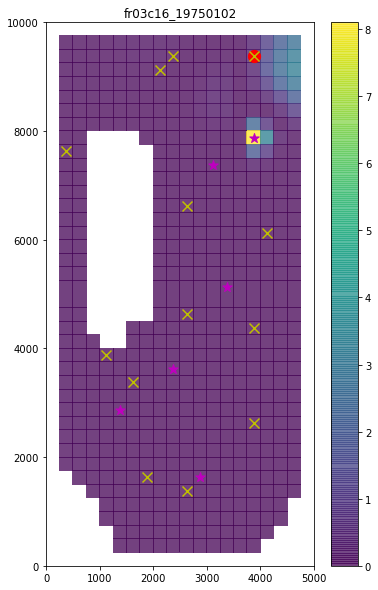

fr03c10_19750102


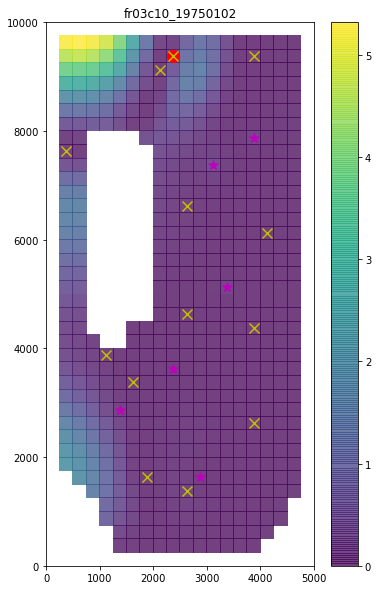

fr04c9_19750102


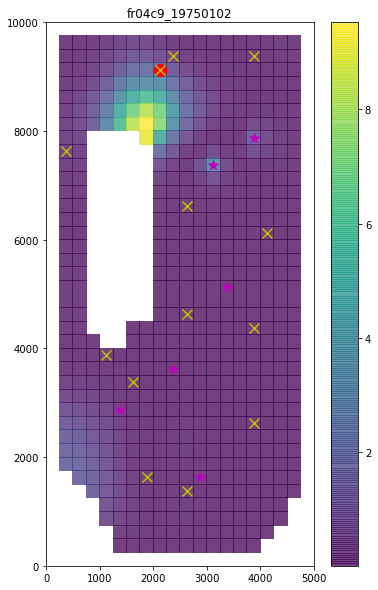

fr10c2_19750102


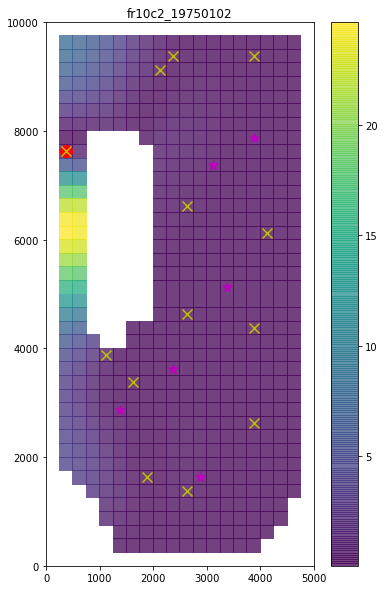

fr14c11_19750102


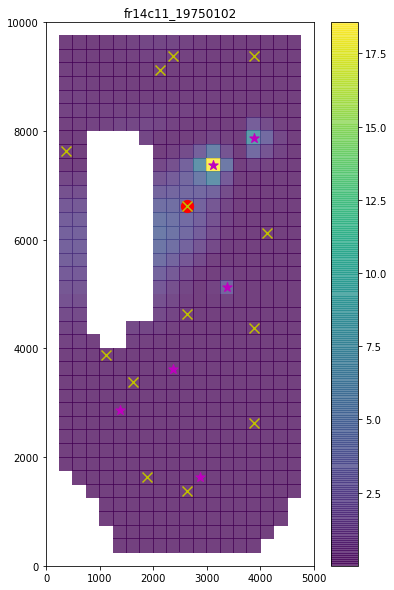

fr16c17_19750102


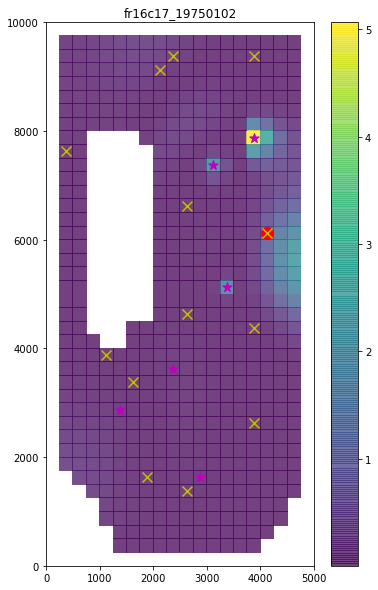

fr22c11_19750102


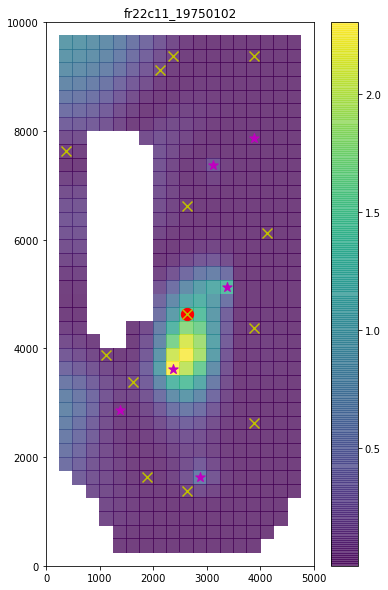

fr23c16_19750102


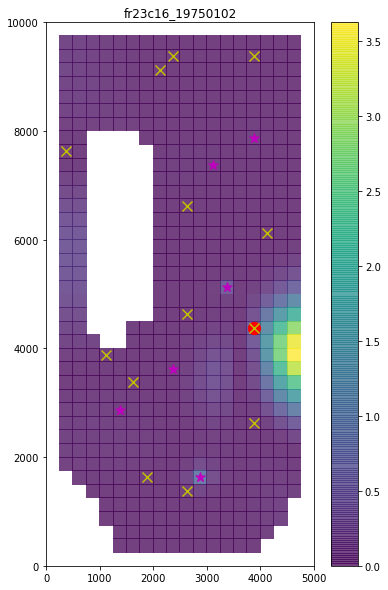

fr25c5_19750102


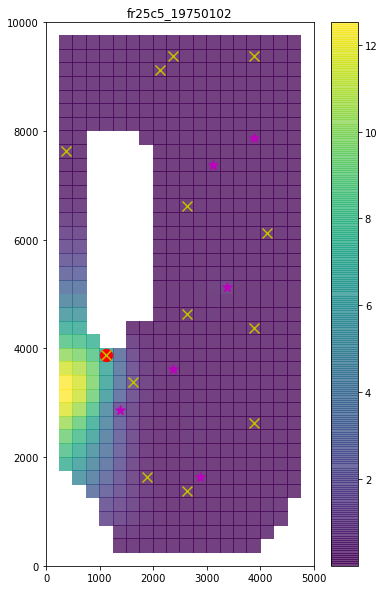

fr27c7_19750102


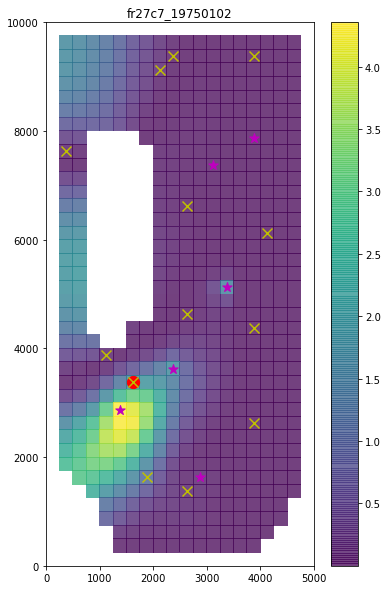

fr30c16_19750102


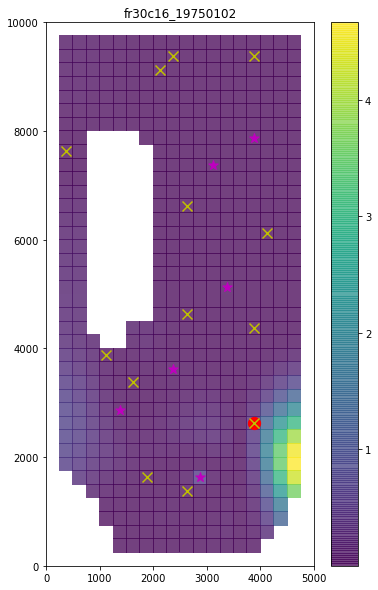

fr34c8_19750102


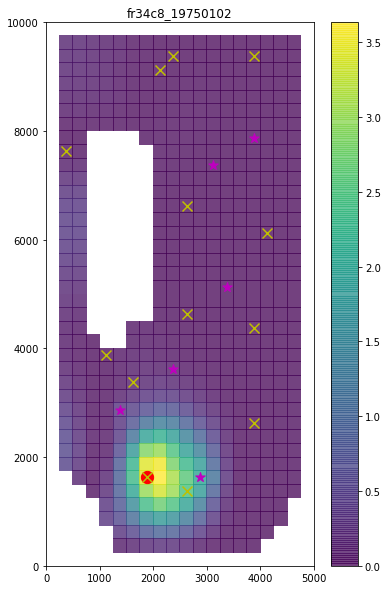

fr35c11_19750102


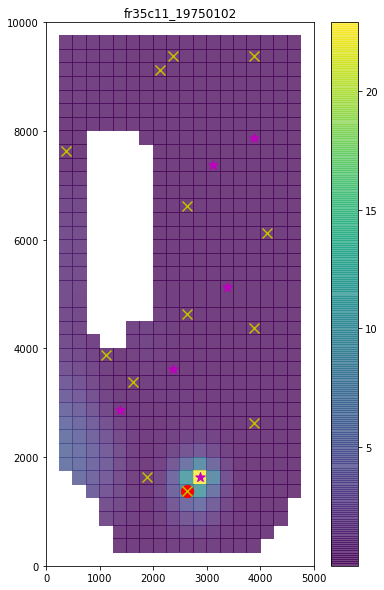

fr02c02_19750102


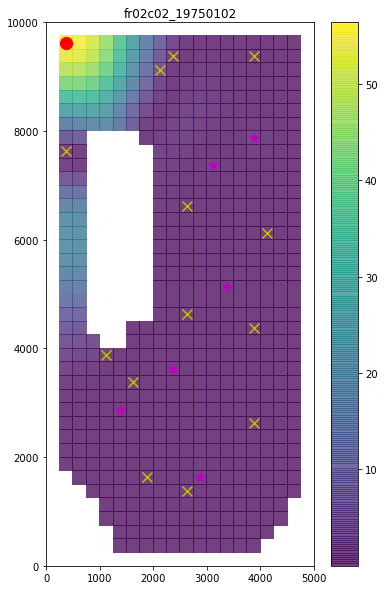

fr01c13_19750102


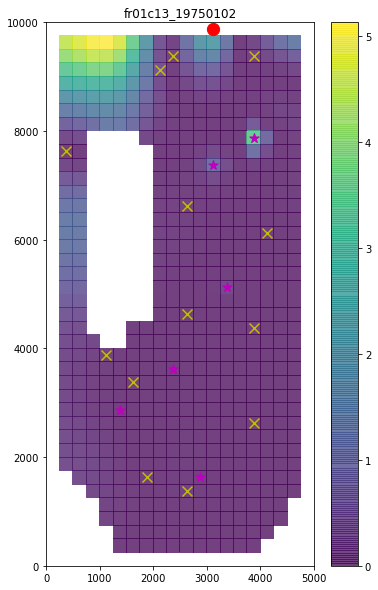

fr09c15_19750102


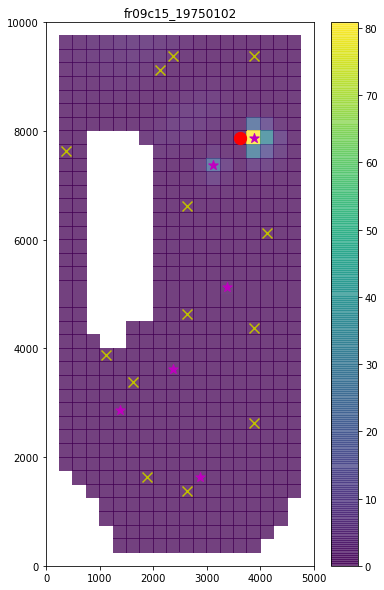

fr25c10_19750102


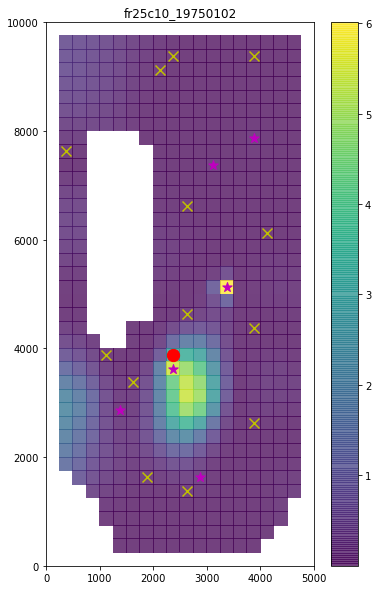

flx_river_l_19750102


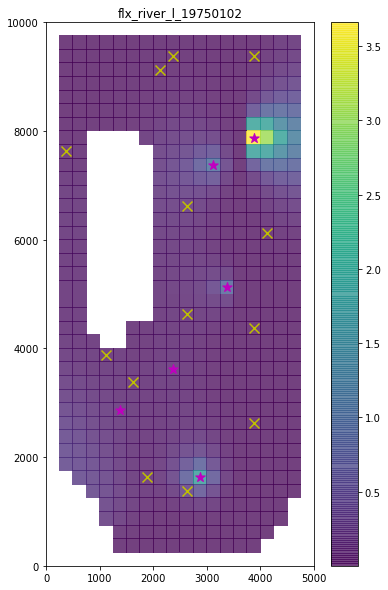

travel_time


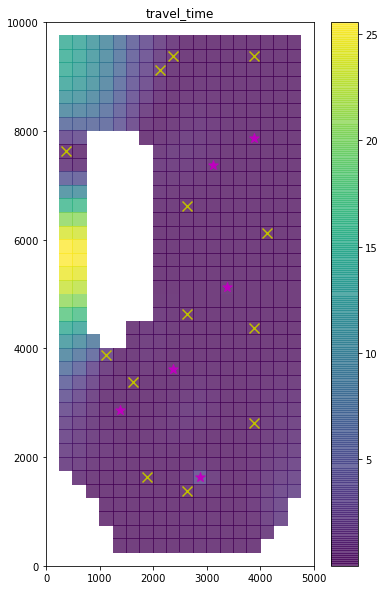

In [28]:
plot_added_worth(df_full)